In [2]:
import gymnasium as gym
from gymnasium import spaces
from collections import deque
import copy
import time

class WaterSortEnvFixed(gym.Env):
    """
    Окружение (environment) WaterSortEnvFixed для игры "Water Sort Puzzle"
    с ФИКСИРОВАННЫМ числом пробирок (N) и максимальным числом слоёв (K).

    Используемые обозначения:
      - N: число пробирок (tube)
      - K: макс. число слоёв (layers) в одной пробирке
      - num_colors: количество различных цветов

    Формат состояния (observation):
      - Матрица размера (N, K) (типа np.array, dtype=int),
      - Каждая строка соответствует одной пробирке.
      - Значение -1 означает "пустой слой",
        а неотрицательные числа (0..num_colors-1) — индекс цвета.

    Пример: state[2][0] = 3 означает,
      что в пробирке #2 верхний слой цвета 3 (если вы считаете индекс 0 верхом).

    Пространство действий (action_space):
      - MultiDiscrete([N, N]),
      - Действие (i, j) означает: "перелить жидкость из пробирки i в пробирку j".
      - При этом i может совпадать с j, но мы будем считать такое действие невалидным
        (можно штрафовать или игнорировать).

    Примечание: Для упрощения считаем,
      что все пробирки имеют одинаковый объём K, и мы не меняем N во время работы.

    Важно: логику корректного переливания (_can_pour, _pour)
    можно модифицировать под точные правила вашей версии Water Sort Puzzle.
    """

    def __init__(self, num_tubes=4, max_layers=4, num_empty=1, num_colors=3, max_steps=300):
        """
        Конструктор окружения WaterSortEnvFixed.

        Параметры:
          num_tubes (int): Число пробирок, N.
          max_layers (int): Максимальное число слоёв в каждой пробирке, K.
          num_colors (int): Число возможных цветов (0..num_colors-1).

        Внутренние переменные:
          self.num_tubes (int): Сохраняем N.
          self.max_layers (int): Сохраняем K.
          self.num_colors (int): Количество цветов.
          self.action_space (gym.spaces.MultiDiscrete): Все пары (i, j),
            i,j из [0..N-1].
          self.observation_space (gym.spaces.Box):
            матрица (N, K), значения в диапазоне [-1, num_colors-1].
          self.state (np.array): Текущее состояние игры (размер N*K).
        """
        super().__init__()
        self.num_tubes = num_tubes     # Число пробирок (N)
        self.max_layers = max_layers   # Число слоёв (K)
        self.num_colors = num_colors   # Кол-во цветов
        self.max_steps = max_steps     # Максимальное число шагов одной игры
        self.num_empty = num_empty     # число пустых колб (L)

        # Пространство действий:
        # Каждое действие -- пара (from_tube, to_tube).
        # Допустимые значения: [0..N-1] для каждой координаты
        self.action_space = spaces.MultiDiscrete([self.num_tubes, self.num_tubes])

        # Пространство наблюдений:
        # Матрица (N, K) с целочисленными значениями от -1 до num_colors-1
        self.observation_space = spaces.Box(
            low=-1,
            high=self.num_colors - 1,
            shape=(self.num_tubes, self.max_layers),
            dtype=int
        )

        # Внутреннее состояние (инициализируется в reset)
        self.state = None

        self.steps = 0  # Счётчик шагов

        self.prev_action = None

        self.prev_state = None

        self.recent_states = deque(maxlen=10)

    def reset(self, seed=None, options=None, previous=False):
        """
        Сброс окружения (начало нового эпизода).
        Возвращает кортеж (observation, info).

        Шаги:
          1) Инициализируем генератор случайных чисел (super().reset(seed=seed)).
          2) Создаем self.state размером (N,K), заполненный -1 (пустыми).
          3) Случайно генерируем какую-то расстановку цветов
             (можно усложнить логику, чтобы гарантировать выполнимость).
          4) Возвращаем текущий observation и пустой словарь info.
        """
        super().reset(seed=seed)

        # Очистим недавние состояния при новом эпизоде
        self.recent_states.clear()

        max_tries = 100
        num_attempts = 0

        if previous and (self.prev_state is not None):
          self.state = self.prev_state.copy()
        else:
          while True:
            # Создаём пустую матрицу (N,K)
            self.state = np.full((self.num_tubes, self.max_layers), -1, dtype=int)

            # Заполняем только первые (num_tubes - 1) трубок.
            total_filled_tubes = self.num_tubes - self.num_empty
            total_slots = total_filled_tubes * self.max_layers


            # Проверяем, что общее число слотов корректно делится на число цветов.
            if total_slots % self.num_colors != 0:
                raise ValueError("Общее число слотов заполненных трубок должно делиться на число цветов.")

            count_per_color = total_slots // self.num_colors  # Количество экземпляров каждого цвета

            # Формируем массив фиксированного количества каждого цвета.
            colors = np.repeat(np.arange(self.num_colors), count_per_color)

            # Перемешиваем массив цветов с использованием генератора случайных чисел окружения.
            self.np_random.shuffle(colors)

            # Заполняем первые (num_tubes - 1) трубок перемешанными цветами.
            idx = 0
            for tube_idx in range(total_filled_tubes):
                for layer_idx in range(self.max_layers):
                    self.state[tube_idx, layer_idx] = colors[idx]
                    idx += 1

            if not self._is_solved():
              # Если НЕ решённая, прерываем цикл
              break

            num_attempts += 1

            if num_attempts >= max_tries:
              # Если слишком много раз попадаем на решённую конфигурацию —
              # прекращаем пытаться и оставляем как есть (пусть будет решённая).
              print("Warning: Could not generate unsolved puzzle. Using solved puzzle.")
              break

        self.steps = 0  # Сброс счетчика шагов для нового эпизода

        observation = self._get_obs()
        self.prev_state = observation
        info = {}
        return observation, info


    def _count_sorted_tubes(self):
        """
        Считает, сколько колб полностью заполнены и одноцветны,
        игнорируя полностью пустые (все -1).
        """
        count = 0
        for tube_idx in range(self.num_tubes):
            tube = self.state[tube_idx]
            # Если трубка содержит хотя бы один -1 => частично пустая => не считаем
            if np.any(tube == -1):
                continue
            # Если все элементы одного цвета:
            if len(set(tube)) == 1:
                count += 1
        return count


    def step(self, action): # Потом убрать проверки плохих ходов так как их быть не может
        """
        Шаг среды (environment step).
        Принимает действие (i, j) — перелить жидкость из пробирки i в j.
        Возвращает (observation, reward, terminated, truncated, info).

        Логика:
          1) Проверить валидность (i != j, i,j < N и т.д.).
          2) Если переливание возможно (_can_pour), то применяем _pour.
          3) Проверяем, решена ли игра (_is_solved).
             - если да, terminated = True и даём награду (reward=1.0).
          4) Иначе reward = 0 или небольшой штраф, если действие было невалидно.
        """
        from_tube, to_tube = action
        reward = -1
        info = {}
        # Проверка: i не должен совпадать с j, индексы должны быть в диапазоне
        if self.prev_action == action:
          reward -= 0.1
          info['Качество хода'] = f"Ход повторился from_tube = {from_tube}, to_tube = {to_tube}"
        else:
          if (from_tube < 0 or from_tube >= self.num_tubes or
              to_tube < 0 or to_tube >= self.num_tubes or
              from_tube == to_tube):
              reward -= 0.05
              info['Качество хода'] = f"Проблема с индексами from_tube = {from_tube}, to_tube = {to_tube}"
          else:
              # Проверяем, можно ли переливать
              if self._can_pour(from_tube, to_tube):
                  sorted_before = self._count_sorted_tubes()
                  self._pour(from_tube, to_tube)
                  sorted_after = self._count_sorted_tubes()
                  if sorted_after > sorted_before:
                    # reward += 0.5 * (sorted_after - sorted_before)
                    reward += 1
                    info['Качество хода'] = f"ход Из = {from_tube}, В = {to_tube}, плюс балл за сортировку"
                  else:
                    info['Качество хода'] = f"ход Из = {from_tube}, В = {to_tube}, обычный ход"
              else:
                  reward -= 0.05
                  info['Качество хода'] = f"Нельзя переливать from_tube = {from_tube}, to_tube = {to_tube}"

        # Нужно сохранять прошлый ход
        self.prev_action = action

        # Проверяем, решена ли игра

        # print(" Насильный рендер перед проверкой")
        # self.render()

        terminated = self._is_solved()
        # if terminated:
            # reward += 10


        # Увеличиваем счётчик шагов
        self.steps += 1

        observation = self._get_obs()
        # Проверяем, достигнут ли лимит шагов или не осталось доступных действий
        # truncated = (self.steps >= self.max_steps) or (len(self.get_valid_actions(observation)) == 0)
        # if not (self.fast_get_valid_actions(observation) == self.get_valid_actions(observation)):
        #     print(observation)
        #     print(f"not_fast {self.get_valid_actions(observation)}")
        #     for move in self.get_valid_actions(observation):
        #         print(f"from_tube: {move // self.num_tubes} to_tube: {move % self.num_tubes}")
        #
        #     print(f"fast {self.fast_get_valid_actions(observation)}")
        #     for move2 in self.fast_get_valid_actions(observation):
        #         print(f"from_tube: {move2 // self.num_tubes} to_tube: {move2 % self.num_tubes}")

        # Проверяем, достигнут ли лимит шагов или не осталось доступных действий
        limit_reached = self.steps >= self.max_steps
        no_moves      = len(self.fast_get_valid_actions(observation.flatten())) == 0

        truncated = limit_reached or no_moves

        info["step_limit_reached"] = bool(limit_reached)
        info["no_valid_moves"] = bool(no_moves)


        # штраф за повтор recent_states
        obs_tuple = tuple(observation.flatten())
        if obs_tuple in self.recent_states:
            reward -= 3.0
            info['repeated_state'] = True
        else:
            info['repeated_state'] = False

        self.recent_states.append(obs_tuple)

        return observation, reward, terminated, truncated, info


    def render(self):
        """
        Визуализация текущего состояния в виде таблицы:
        - Ось X: номера трубок.
        - Ось Y: номера слоёв.
        """
        for layer in range(self.max_layers):
            row = f"Layer {layer:>2}: " + " ".join(f"{self.state[tube, layer]:>3}" for tube in range(self.num_tubes))
            print(row)
        print()

    # =============================================================================
    # -------------------------- Вспомогательные методы ---------------------------
    # =============================================================================

    def _get_obs(self):
        """
        Возвращает копию текущего состояния (self.state) в формате np.array,
        чтобы не было побочных эффектов.
        """
        return np.array(self.state, copy=True)


    def _is_solved(self):
        for tube_idx in range(self.num_tubes):
            tube = self.state[tube_idx]

            # Если трубка вся пустая, ок
            if np.all(tube == -1):
                continue

            # Иначе проверим, что нет -1 и только один цвет
            if np.any(tube == -1):
                # Есть смесь пустых и заполненных -> не решено
                return False

            # Проверяем, что единственный цвет
            unique_colors = set(tube)  # без [tube != -1]
            if len(unique_colors) != 1:
                # более одного цвета -> не решено
                return False

        return True

    def _can_pour(self, from_tube, to_tube):
        """
        Проверяем, можно ли переливать жидкость из пробирки from_tube в to_tube
        по правилам Water Sort. Упрощённый вариант:
          1) from_tube не пустая (есть хотя бы один слой != -1).
          2) to_tube не переполнена (есть хотя бы один -1).
          3) Цвет верхнего слоя from_tube совпадает с цветом верхнего слоя to_tube
             (или to_tube пустая).
        """
        # Найдём индекс верхнего слоя from_tube
        from_top = self._find_top(from_tube)
        if from_top == -1:
            return False  # from_tube пустая

        # Аналогично для to_tube
        to_top = self._find_top(to_tube)

        # Если to_tube полностью заполнена -> нельзя
        if to_top == 0:
            return False

        from_color = self.state[from_tube, from_top]
        if to_top == -1:
            # Значит to_tube вообще пустая (все -1),
            # по упрощённым правилам: переливать можно
            return True
        else:
            to_color = self.state[to_tube, to_top]
            # Разрешаем переливать только если цвета совпадают
            return (from_color == to_color)

    def _pour(self, from_tube, to_tube):
        """
        Логика переливания жидкости (упрощённая):
          - Определяем, какой слой является верхним в from_tube.
          - Смотрим, сколько подряд слоёв такого же цвета над ним (вверх).
          - Переносим максимально возможное количество слоёв в to_tube,
            пока не кончится место или не сменится цвет.

        """
        from_idx = self._find_top(from_tube)
        # if from_idx == -1:
        #     return  # Нечего переливать, эта проверка есть в _can_pour, не знаю может ее удалить

        color = self.state[from_tube, from_idx]

        # Считаем, сколько подряд слоёв этого цвета "сверху"
        count = 1
        check_idx = from_idx + 1
        while check_idx < self.max_layers and self.state[from_tube, check_idx] == color:
            count += 1
            check_idx += 1

        # Найдём, куда "наливать" в to_tube:
        to_idx = self._find_top(to_tube)
        if to_idx == -1:
            # Пустая пробирка, начинаем заливать снизу вверх
            to_idx = self.max_layers - 1
        else:
            # Если to_idx уже занят, мы начинаем наливать "выше" — на to_idx+1
            to_idx -= 1

        # Переливаем послойно
        while count > 0 and to_idx >= 0:
            # Проверяем, что to_idx ещё пуст
            if self.state[to_tube, to_idx] == -1:
                # Переливаем цвет
                self.state[to_tube, to_idx] = color
                # Убираем из from
                self.state[from_tube, from_idx] = -1

                # Сдвигаемся дальше
                from_idx += 1
                to_idx -= 1
                count -= 1
            else:
                break  # to_tube заполнена или цвет не подходит

    def _find_top(self, tube_idx):
        """
        Находим "верхний слой" в пробирке tube_idx.
        Предположим, что индекс 0 - это самый верх, а индекс K-1 - самый низ.
        Возвращаем индекс слоя (int) или -1, если пробирка пустая.

        Логика: ищем первый индекс i с 0 до K-1,
        где self.state[tube_idx, i] != -1.
        Если не нашли, значит пусто -> -1.
        """
        tube = self.state[tube_idx]
        for i in range(self.max_layers):
            if tube[i] != -1:
                return i
        return -1


    def _can_pour_obs(self, obs_2d, from_tube, to_tube):
        from_top = self._find_top_obs(obs_2d, from_tube)
        if from_top == -1:
            return False
        to_top = self._find_top_obs(obs_2d, to_tube)
        if to_top == 0:
            return False
        from_color = obs_2d[from_tube, from_top]
        if to_top == -1:
            return True
        else:
            to_color = obs_2d[to_tube, to_top]
            return (from_color == to_color)


    def _find_top_obs(self, obs_2d, tube_idx):
        for i in range(self.max_layers):
            if obs_2d[tube_idx, i] != -1:
                return i
        return -1


    # def get_valid_actions(self, flat_obs):
    #     obs_2d = flat_obs.reshape(self.num_tubes, self.max_layers)
    #     valid_acts = []
    #     N = self.num_tubes
    #     for a in range(N*N):
    #         from_tube = a // N
    #         to_tube   = a % N
    #         if from_tube != to_tube and self._can_pour_obs(obs_2d, from_tube, to_tube) and (from_tube, to_tube) != self.prev_action:
    #             valid_acts.append(a)
    #     return valid_acts

    def fast_get_valid_actions(self, flat_obs, *, ignore_prev=False):
        N, K = self.num_tubes, self.max_layers
        obs = flat_obs.reshape(N, K) if flat_obs.ndim == 1 else flat_obs

        is_empty = (obs == -1).all(axis=1)
        first_filled = np.where(is_empty, K, (obs != -1).argmax(axis=1))
        free_space   = K - (K - first_filled)          # ≤ K, 0 == нет места

        top_color = np.full(N, -2, dtype=int)
        filled_mask = ~is_empty
        top_color[filled_mask] = obs[filled_mask, first_filled[filled_mask]]

        can_from = ~is_empty
        can_to   = free_space > 0                      # исправили «top_idx>0»

        same_or_empty = (top_color[:, None] == top_color[None, :]) | is_empty[None, :]

        mask = can_from[:, None] & can_to[None, :] & same_or_empty
        np.fill_diagonal(mask, False)

        # убрать прошлое действие
        if (not ignore_prev) and (self.prev_action is not None):
            mask.flat[self.prev_action[0]*N + self.prev_action[1]] = False

        return np.flatnonzero(mask.ravel()).tolist()


class DiscreteActionWrapper(gym.Wrapper):
    """
    Превращаем MultiDiscrete(N,N) -> Discrete(N*N).
    Разворачиваем наблюдение (N,K) в вектор (N*K).
    """
    def __init__(self, env):
        super().__init__(env)
        self.env = env
        N = env.num_tubes
        self.action_space = gym.spaces.Discrete(N * N)
        self.observation_space = gym.spaces.Box(
            low=-1,
            high=self.env.num_colors - 1,
            shape=(self.env.num_tubes * self.env.max_layers,),
            dtype=int
        )

    @property
    def max_steps(self):
        return self.env.max_steps

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        return obs.flatten(), info

    def step(self, action):
        N = self.env.num_tubes
        from_tube = action // N
        to_tube = action % N
        obs, reward, done, truncated, info = self.env.step((from_tube, to_tube))
        return obs.flatten(), reward, done, truncated, info

    def fast_get_valid_actions(self, flat_obs, *, ignore_prev=False):
        """
        Проброс к базовому окружению (необёрнутому).
        """
        # return self.env.get_valid_actions(flat_obs)
        return self.env.fast_get_valid_actions(flat_obs, ignore_prev=ignore_prev)


In [3]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange
import matplotlib.pyplot as plt
# from IPython.display import clear_output



class MaskedDQNAgent(nn.Module):
    def __init__(self, state_dim, action_dim, net_arch=[256,256], lr=1e-4, device='cpu'):
        super().__init__()
        self.device = device
        # Q-сеть
        layers = []
        input_dim = state_dim
        for units in net_arch:
            layers.append(nn.Linear(input_dim, units))
            layers.append(nn.ReLU())
            input_dim = units
        layers.append(nn.Linear(input_dim, action_dim))
        self.q_net = nn.Sequential(*layers).to(device)

        # Target-сеть
        self.q_net_target = copy.deepcopy(self.q_net).to(device)
        for p in self.q_net_target.parameters():
            p.requires_grad = False

        self.epsilon = 1.0
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.to(device)

    def forward(self, x):
        return self.q_net(x)

    def predict_qvalues(self, obs: np.ndarray) -> np.ndarray:
        """
        Текущее Q(s,a) (numpy).
        """
        if isinstance(obs, np.ndarray):
            obs = torch.FloatTensor(obs).to(self.device)
        with torch.no_grad():
            qvals = self.q_net(obs).cpu().numpy()
        return qvals

    def predict_qvalues_target(self, obs_t: torch.Tensor) -> torch.Tensor:
        """
        Q(s,a) от target сети, возвращаем PyTorch-тензор (batch_size, action_dim).
        """
        # obs_t уже на нужном устройстве
        with torch.no_grad():
            qvals = self.q_net_target(obs_t)
        return qvals


    def sample_actions_masked(self, obs: np.ndarray, env) -> np.ndarray:
        qvals = self.predict_qvalues(obs)            # numpy (B, A)
        B, A = qvals.shape
        actions = np.empty(B, dtype=int)

        for i in range(B):
            valid = env.fast_get_valid_actions(obs[i])
            if not valid:
                valid = list(range(A))
            if random.random() < self.epsilon:
                actions[i] = random.choice(valid)
            else:
                # вместо цикла сделаем маску
                mask = np.full(A, -1e9, dtype=np.float32)
                mask[valid] = 0.0
                q_masked = qvals[i] + mask           # invalid≤-1e9
                actions[i] = q_masked.argmax()

        return actions

    def update_target(self):
        self.q_net_target.load_state_dict(self.q_net.state_dict())

In [4]:
def compute_masked_dqn_loss(agent: MaskedDQNAgent, env, batch, gamma=0.99, device='cpu'):
    """
    Полная маскировка: и при выборе действия (уже есть sample_actions_masked),
    и при вычислении таргета.
    """
    states, actions, rewards, next_states, dones = batch
    batch_size = len(states)

    states_t = torch.FloatTensor(states).to(device)       # (batch_size, state_dim)
    actions_t = torch.LongTensor(actions).to(device)      # (batch_size,)
    rewards_t = torch.FloatTensor(rewards).to(device)     # (batch_size,)
    next_states_t = torch.FloatTensor(next_states).to(device)
    dones_t = torch.BoolTensor(dones).to(device)

    # Q(s,a) текущей сети
    q_values = agent.q_net(states_t)  # (batch_sizаe, action_dim)
    q_taken = q_values[range(batch_size), actions_t]

    # Target: masked max Q(s',a') на target-сети
    with torch.no_grad():
        # Предварительно считаем q_target для всех a'
        q_next_target = agent.q_net_target(next_states_t)  # shape (batch_size, action_dim)
        q_next_target_np = q_next_target.cpu().numpy()     # переводим в numpy для маскировки

        masked_max_q = np.zeros(batch_size, dtype=np.float32)
        for i in range(batch_size):
            if dones[i]:
                # Если эпизод завершён — нет будущих наград
                masked_max_q[i] = 0.0
            else:
                # Нужно получить список валидных действий для next_states[i]
                # valid_acts = env.fast_get_valid_actions(next_states[i])
                valid_acts = env.fast_get_valid_actions(next_states[i], ignore_prev=True)
                if len(valid_acts) == 0:
                    # fallback: все действия
                    valid_acts = list(range(q_next_target_np.shape[1]))

                masked_q = q_next_target_np[i].copy()
                invalid_acts = set(range(q_next_target_np.shape[1])) - set(valid_acts)
                for inv_a in invalid_acts:
                    masked_q[inv_a] = -1e9

                masked_max_q[i] = masked_q.max()

        masked_max_q_t = torch.FloatTensor(masked_max_q).to(device)
        target = rewards_t + gamma * masked_max_q_t * (~dones_t)

    loss = ((q_taken - target) ** 2).mean()
    return loss


In [5]:
class ReplayBuffer:
    def __init__(self, capacity=10**5):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size=64):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=bool)
        )

    def __len__(self):
        return len(self.buffer)

In [6]:
# %%──────────────────────────────────────────────────────────────────────────────
import time, numpy as np

# ────────────────────────────────────────────────────────────────────────────────
def solve_optimal_path(wrapped_env,
                       flat_obs: np.ndarray,
                       max_expansions: int = 100_000):
    """
    BFS-поиск кратчайшего решения для текущего состояния.

    Возврат:
        path        – список действий (формат Discrete, как в env.action_space)
        length      – длина решения (None, если не найдено)
        expansions  – сколько состояний было развёрнуто
        t_seconds   – время работы поиска
    """
    # параметры головоломки
    env = wrapped_env.env
    N, K = env.num_tubes, env.max_layers

    start_tuple = tuple(flat_obs)                 # неизменяемое представление

    # ── вспомогательные чистые функции на numpy-матрицах ──────────────────────
    def is_solved(mat: np.ndarray) -> bool:
        for t in range(N):
            tube = mat[t]
            if np.all(tube == -1):                     # полностью пустая
                continue
            if np.any(tube == -1) or len(set(tube)) != 1:
                return False
        return True

    def find_top(mat, tube):
        for i in range(K):
            if mat[tube, i] != -1:
                return i
        return -1

    def can_pour(mat, fr, to):
        if fr == to:
            return False
        fr_top = find_top(mat, fr)
        if fr_top == -1:
            return False
        to_top = find_top(mat, to)
        if to_top == 0:                              # приёмник полон
            return False
        from_color = mat[fr, fr_top]
        return (to_top == -1) or (mat[to, to_top] == from_color)

    def pour(mat, fr, to):
        """возвращает НОВУЮ матрицу после переливания fr→to"""
        mat = mat.copy()
        fr_top = find_top(mat, fr)
        color  = mat[fr, fr_top]

        # сколько одинаковых цветных слоёв сверху?
        count = 1
        idx = fr_top + 1
        while idx < K and mat[fr, idx] == color:
            count += 1; idx += 1

        to_top = find_top(mat, to)
        to_idx = K - 1 if to_top == -1 else to_top - 1

        while count and to_idx >= 0 and mat[to, to_idx] == -1:
            mat[to, to_idx] = color
            mat[fr, fr_top] = -1
            fr_top += 1
            to_idx -= 1
            count -= 1
        return mat

    # ── сам BFS ───────────────────────────────────────────────────────────────
    t0 = time.time()
    q = deque([(start_tuple, [])])
    visited = {start_tuple}
    expansions = 0

    while q and expansions < max_expansions:
        state_tuple, path = q.popleft()
        state_mat = np.array(state_tuple).reshape(N, K)

        if is_solved(state_mat):
            return path, len(path), expansions, time.time() - t0

        for a in wrapped_env.fast_get_valid_actions(np.array(state_tuple),
                                                    ignore_prev=True):
            fr, to = divmod(a, N)
            if not can_pour(state_mat, fr, to):
                continue
            nxt = pour(state_mat, fr, to)
            nxt_tuple = tuple(nxt.flatten())
            if nxt_tuple not in visited:
                visited.add(nxt_tuple)
                q.append((nxt_tuple, path + [a]))

        expansions += 1

    # не нашли решение
    return [], None, expansions, time.time() - t0

In [7]:
from IPython.display import clear_output
import numpy as np, matplotlib.pyplot as plt

def draw_graphs(r_all, s_all,
                r_clean, s_clean,
                s_math, delt,                       # NEW
                n_win, n_limit, n_nomove,
                eval_period, total_timesteps):
    """
    ┌──────────────┬──────────────┐   ① mean reward   │ ② mean steps
    ├──────────────┴──────────────┤
    │ ③ episode counters │ ④ summary table
    ├─────────────────────────────┤
    │           ⑤ Δ-steps         │                (span)
    └─────────────────────────────┘
    """
    clear_output(wait=True)
    print(1)
    x = np.arange(1, len(r_all) + 1) * eval_period

    fig = plt.figure(figsize=(18, 15))
    gs  = fig.add_gridspec(3, 2,
                           height_ratios=[1, 0.9, 0.6],
                           width_ratios =[1, 0.8])

    # ① Mean reward
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.set_title("Mean reward")
    ax0.plot(x, r_all,   label="all")
    ax0.plot(x, r_clean, label="clean")
    ax0.set_ylabel("R"); ax0.grid(); ax0.legend()

    # ② Mean steps (+ ideal)
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.set_title("Mean steps")
    ax1.plot(x, s_all,   label="all")
    ax1.plot(x, s_clean, label="clean")
    ax1.plot(x, s_math,  label="ideal")        # ideal = мат-решение
    ax1.set_ylabel("steps"); ax1.grid(); ax1.legend()

    # ③ Episode counters
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.set_title("Episode counters / evaluation")
    ax2.plot(x, n_win,    label="wins")
    ax2.plot(x, n_limit,  label="step-limit")
    ax2.plot(x, n_nomove, label="no-moves")
    ax2.set_xlabel(f"env steps (×{eval_period})")
    ax2.set_ylabel("episodes / 100 runs")
    ax2.grid(); ax2.legend()

    # ④ Summary table
    ax3 = fig.add_subplot(gs[1, 1]);  ax3.axis("off")
    last = lambda arr: (arr[-1] if arr else float("nan"))
    table_data = [
        ["reward all",   f"{last(r_all):.2f}"],
        ["reward clean", f"{last(r_clean):.2f}"],
        ["steps  all",   f"{last(s_all):.1f}"],
        ["steps  clean", f"{last(s_clean):.1f}"],
        ["steps  math",  f"{last(s_math):.1f}"],
        ["Δ clean-math", f"{last(delt):+.1f}"],
        ["wins",         int(last(n_win))],
        ["Решаемый-зациклился",   int(last(n_limit))],
        ["Не решаемый",     int(last(n_nomove))],
    ]
    tbl = ax3.table(cellText=table_data,
                    colLabels=["Metric", "Last value"],
                    loc="center", cellLoc="center")
    tbl.scale(1, 2.1); tbl.auto_set_font_size(False); tbl.set_fontsize(12)

    # ⑤ Δ-steps plot
    ax4 = fig.add_subplot(gs[2, 0])            # ⬅ берём только 1-ю колонку
    ax_dummy = fig.add_subplot(gs[2, 1])       # пустая ячейка-заглушка
    ax_dummy.axis("off")
    ax4.set_title("Δ-steps (clean − math)")
    ax4.plot(x, delt, label="Δ steps", color="tab:red")
    ax4.set_xlabel("environment steps"); ax4.set_ylabel("Δ"); ax4.grid(); ax4.legend()

    fig.tight_layout(); plt.show()

    return fig


In [8]:
# %%──────────────────────────────────────────────────────────────────────────────
def evaluate_by_mean(env_eval,
                     agent,
                     n_games: int,
                     bfs_timeout: int = 100_000):
    """
    Возврат:
        mean_reward_all, mean_steps_all,
        mean_reward_clean, mean_steps_clean,
        mean_steps_math,           # ∅ → nan
        delta_steps,               # mean_steps_clean - mean_steps_math
        n_win_games, n_step_limit, n_no_moves
    """
    rewards_all, steps_all          = [], []
    rewards_clean, steps_clean      = [], []
    steps_math                       = []

    n_win_games = n_step_limit = n_no_moves = 0

    for _ in range(n_games):
        # ───── стартовая позиция ──────────────────────────────────────────
        obs0, _ = env_eval.reset(previous=False)
        obs     = obs0.copy()
        total_r = agent_steps = 0

        # ───── игра агента ────────────────────────────────────────────────
        while True:
            old_eps, agent.epsilon = agent.epsilon, 0.0
            act  = agent.sample_actions_masked(obs[None], env_eval)[0]
            agent.epsilon = old_eps

            obs, rew, terminated, truncated, info = env_eval.step(act)
            total_r   += rew
            agent_steps += 1

            if terminated or truncated:
                # if terminated:               # победа
                #     n_win_games += 1
                # if info.get("step_limit_reached"):
                #     n_step_limit += 1
                # if info.get("no_valid_moves"):
                #     n_no_moves   += 1
                break

        # ───── статистика ────────────────────────────────────────────────
        rewards_all.append(total_r)
        steps_all.append(agent_steps)

        clean_ep = (not info.get("step_limit_reached")
                    and not info.get("no_valid_moves"))

        if clean_ep:
            rewards_clean.append(total_r)
            steps_clean.append(agent_steps)
            n_win_games += 1

            # — оптимальный путь только для «чистых» побед —
            if terminated:                            # win-эпизод
                path_opt, len_opt, *_ = solve_optimal_path(
                    env_eval, obs0, max_expansions=bfs_timeout)
                if len_opt is not None:
                    steps_math.append(len_opt)
        else: # определяем решается ли уровень вообще
            path_opt, len_opt, *_ = solve_optimal_path(
                    env_eval, obs0, max_expansions=bfs_timeout)
            if len_opt is not None:
                n_step_limit += 1  # это значит что уровень решаемый но агент сам себя завел в цикл
            else:
                n_no_moves   += 1 # это значит что уровень нерешаемый и поэтому агент в цикле


    # ───── агрегаты ───────────────────────────────────────────────────────
    mean_reward_all   = float(np.mean(rewards_all))
    mean_steps_all    = float(np.mean(steps_all))
    mean_reward_clean = (float(np.mean(rewards_clean))
                         if rewards_clean else float("nan"))
    mean_steps_clean  = (float(np.mean(steps_clean))
                         if steps_clean  else float("nan"))
    mean_steps_math   = (float(np.mean(steps_math))
                         if steps_math   else float("nan"))
    delta_steps       = (mean_steps_clean - mean_steps_math
                         if not np.isnan(mean_steps_math) else float("nan"))

    return (mean_reward_all,  mean_steps_all,
            mean_reward_clean, mean_steps_clean,
            mean_steps_math, delta_steps,
            n_win_games, n_step_limit, n_no_moves)


In [9]:
def train_masked_dqn(env, env_eval, agent, total_timesteps=200_000, device='cpu', evaluate_interval=10000):
    # Параметры
    buffer_size = 10**5
    batch_size = 64
    learning_starts = 10_000
    train_freq = 4
    target_update_interval = 10_000

    gamma = 0.99

    exploration_fraction = 0.5
    exploration_final_eps = 0.1
    max_grad_norm = 10.0



    replay_buffer = ReplayBuffer(capacity=buffer_size)

    def linear_epsilon(step):
        fraction = min(step / (exploration_fraction * total_timesteps), 1.0)
        return 1.0 + fraction * (exploration_final_eps - 1.0)

    # Начальное заполнение
    obs, _ = env.reset()
    for _ in range(learning_starts):
        # action = env.action_space.sample()
        valid = env.fast_get_valid_actions(obs)
        if not valid:                     # редкий случай (быстро решённая головоломка)
            action_valid = env.action_space.sample()
        else:
            action_valid = random.choice(valid)
        next_obs, reward, done, truncated, _ = env.step(action_valid)
        replay_buffer.add(obs, action_valid, reward, next_obs, done or truncated)
        obs = next_obs
        if done or truncated:
            obs, _ = env.reset()

    # Логгеры
    rewards_history = []
    steps_history = []

    # тута
    evaluate_rewards_all = []
    evaluate_steps_all = []
    evaluate_rewards_clean = []
    evaluate_steps_clean = []
    evaluate_n_win_games = []
    evaluate_n_step_limit = []
    evaluate_n_no_moves = []
    evaluate_steps_math    = []
    evaluate_delta_steps   = []

    ep_reward = 0.0
    ep_steps = 0

    obs, _ = env.reset()
    global_step = 0

    for step in trange(total_timesteps):
        # eps
        agent.epsilon = linear_epsilon(step)

        # Делаем masked выбор
        action_masked = agent.sample_actions_masked(obs[None], env)[0]


        # Шаг в среде
        next_obs, reward, done, truncated, _ = env.step(action_masked)
        replay_buffer.add(obs, action_masked, reward, next_obs, done or truncated)
        obs = next_obs

        ep_reward += reward
        ep_steps += 1
        global_step += 1

        if done or truncated:
            rewards_history.append(ep_reward)
            steps_history.append(ep_steps)
            ep_reward = 0.0
            ep_steps = 0
            obs, _ = env.reset()

        # Обучаем
        if global_step % train_freq == 0:
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                loss = compute_masked_dqn_loss(agent, env, batch, gamma, device=device)

                agent.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
                agent.optimizer.step()

        # Обновляем target
        if global_step % target_update_interval == 0:
            agent.update_target()

        # Оценка
        if global_step % evaluate_interval == 0:
            # вот тут надо epsilon отключить
            (mean_r_all, mean_s_all,
             mean_r_clean, mean_s_clean,
             mean_s_math, delta_steps,
             n_win, n_limit, n_no_moves) = evaluate_by_mean(
                    env_eval, agent, n_games=100, bfs_timeout=100_000)

            evaluate_rewards_all  .append(mean_r_all)
            evaluate_steps_all    .append(mean_s_all)
            evaluate_rewards_clean.append(mean_r_clean)
            evaluate_steps_clean  .append(mean_s_clean)
            evaluate_steps_math   .append(mean_s_math)     # NEW
            evaluate_delta_steps  .append(delta_steps)     # NEW
            evaluate_n_win_games .append(n_win)
            evaluate_n_step_limit.append(n_limit)
            evaluate_n_no_moves  .append(n_no_moves)

            figs = draw_graphs(evaluate_rewards_all, evaluate_steps_all,
                        evaluate_rewards_clean, evaluate_steps_clean,
                        evaluate_steps_math, evaluate_delta_steps,              # NEW
                        evaluate_n_win_games, evaluate_n_step_limit,
                        evaluate_n_no_moves,
                        evaluate_interval, total_timesteps)

    return agent, rewards_history, steps_history, figs


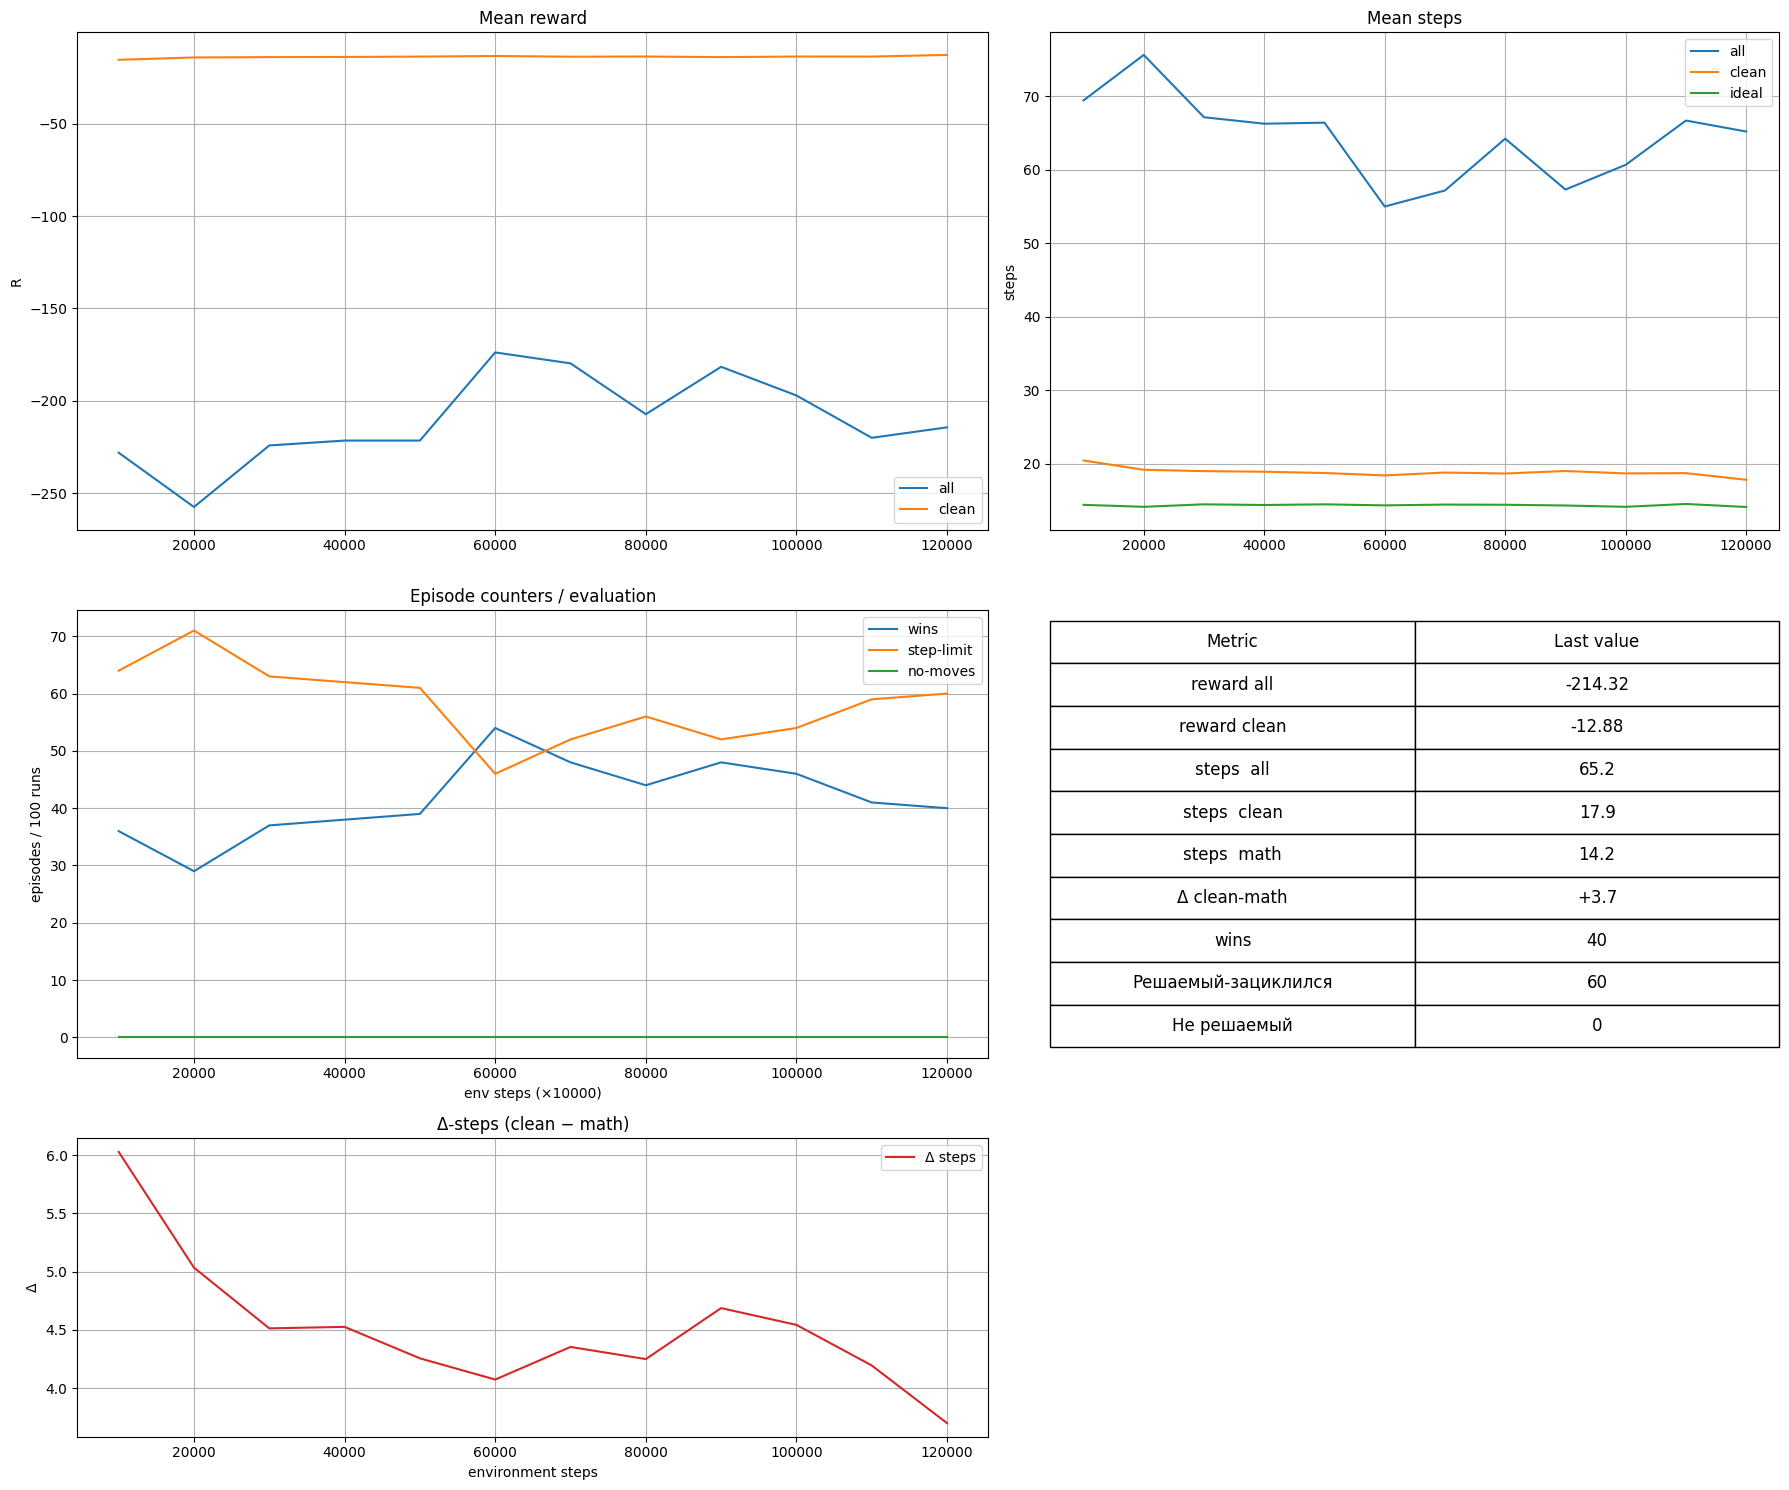

 26%|██▌       | 129999/500000 [27:43<1:18:53, 78.16it/s] 


KeyboardInterrupt: 

In [491]:
"""
Обучение модели
"""
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
# шото новое
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True

n = 7 # кол-во колб
k = 2 # сколько оставляем пустых
l = 4 # кол-во слоев
max_steps_per_game = 100
base_env = WaterSortEnvFixed(num_tubes=n, max_layers=l, num_empty=k, num_colors=n-k, max_steps=max_steps_per_game)
env = DiscreteActionWrapper(base_env)

base_env_eval = WaterSortEnvFixed(num_tubes=n, max_layers=l, num_empty=k, num_colors=n-k, max_steps=max_steps_per_game)
env_eval = DiscreteActionWrapper(base_env_eval)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

lr = 1e-4
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n

agent = MaskedDQNAgent(
        state_dim=obs_dim,
        action_dim=act_dim,
        net_arch=[(n*(n-1))*25, (n*(n-1))*10],
        lr=lr,
        device=device
    )


total_timesteps = 500_000
evaluate_interval = total_timesteps // 10

agent, rewards_history, steps_history, graph = train_masked_dqn(env, env_eval, agent, total_timesteps=total_timesteps, device=device,evaluate_interval=evaluate_interval)

In [490]:
torch.save(agent.state_dict(), f"relevante/dqn_{n}_{k}_{l}_{total_timesteps}.pth")
graph.savefig(f"graphs/dqn_{n}_{k}_{l}_{total_timesteps}.png")

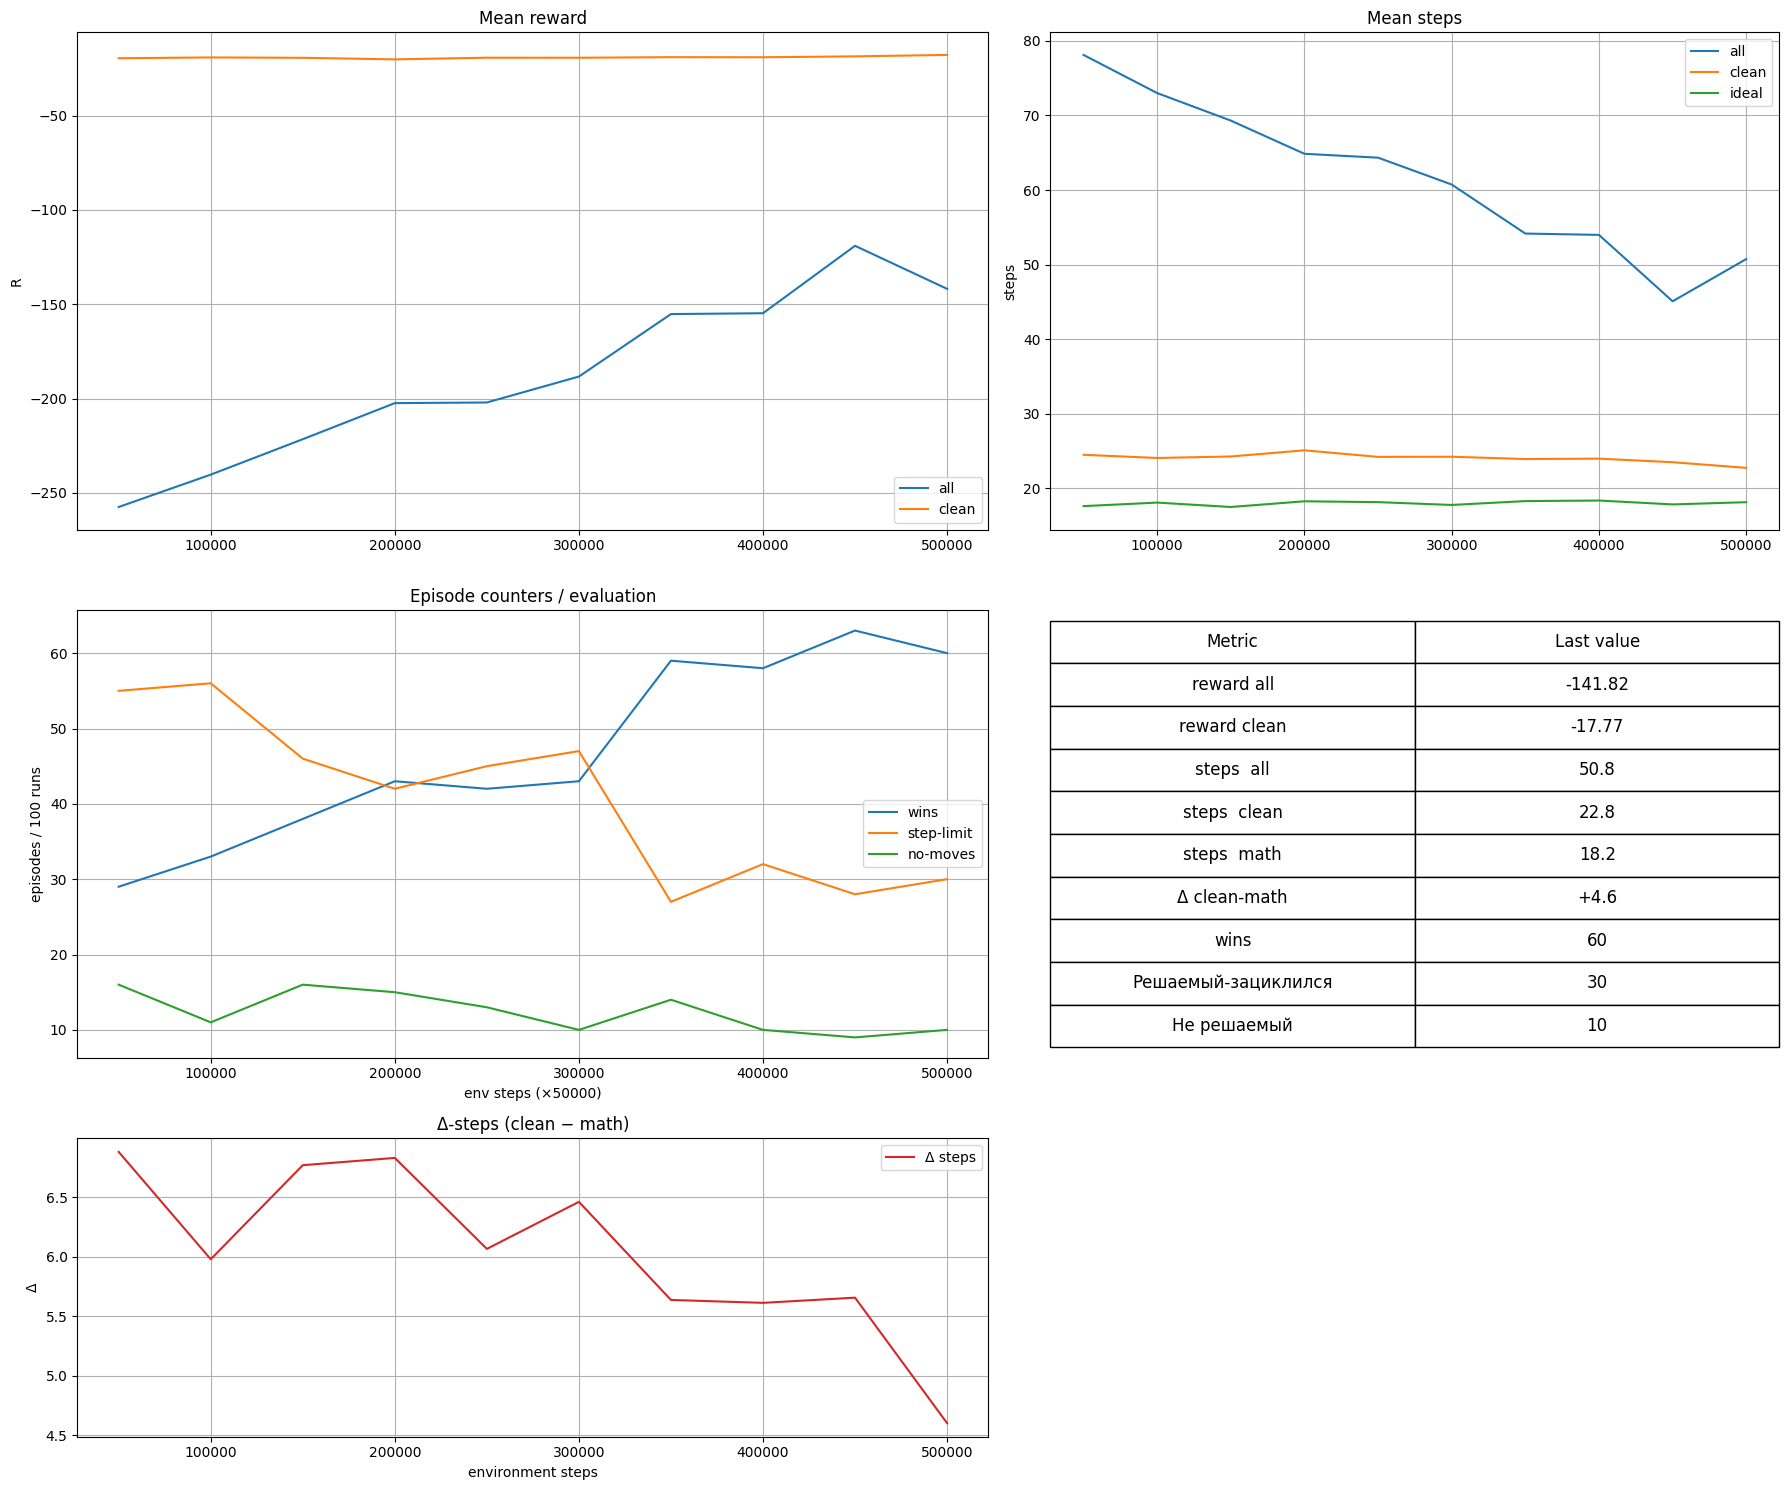

100%|██████████| 500000/500000 [1:03:19<00:00, 131.59it/s]


In [493]:
"""
Обучение несколько моделей
"""
filenames = [
    "3_1_4", "3_1_5",
    "4_1_4", "4_1_5",
    "4_2_4", "4_2_5",
    "5_1_4", "5_1_5",
    "5_2_4", "5_2_5",
    "7_2_4", "7_2_5"
]
total_timesteps = 500_000
evaluate_interval = total_timesteps // 10
for name in filenames:
    n, k, l = map(int, name.split('_'))
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)

    # шото новое
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True

    # n = 7 # кол-во колб
    # k = 2 # сколько оставляем пустых
    # l = 4 # кол-во слоев
    max_steps_per_game = 100
    base_env = WaterSortEnvFixed(num_tubes=n, max_layers=l, num_empty=k, num_colors=n-k, max_steps=max_steps_per_game)
    env = DiscreteActionWrapper(base_env)

    base_env_eval = WaterSortEnvFixed(num_tubes=n, max_layers=l, num_empty=k, num_colors=n-k, max_steps=max_steps_per_game)
    env_eval = DiscreteActionWrapper(base_env_eval)

    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    lr = 1e-4
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n

    agent = MaskedDQNAgent(
            state_dim=obs_dim,
            action_dim=act_dim,
            net_arch=[(n*(n-1))*25, (n*(n-1))*10],
            lr=lr,
            device=device
        )

    # evaluate_interval = 10_000
    # total_timesteps = 500_000

    agent, rewards_history, steps_history, graph = train_masked_dqn(env, env_eval, agent, total_timesteps=total_timesteps, device=device,evaluate_interval=evaluate_interval)

    torch.save(agent.state_dict(), f"relevante/dqn_{n}_{k}_{l}_{total_timesteps}.pth")
    if graph is not None:
        graph.savefig(f"graphs/dqn_{n}_{k}_{l}_{total_timesteps}.png")
        plt.close(graph)

In [ ]:
# """
# Загрузка модели
# """
#
# random.seed(42)
# np.random.seed(42)
# torch.manual_seed(42)
#
# n = 7 # кол-во колб
# k = 2 # сколько оставляем пустых
# l = 4 # кол-во слоев
# max_steps_per_game = 100
# base_env = WaterSortEnvFixed(num_tubes=n, max_layers=4, num_empty=k, num_colors=n-k, max_steps=max_steps_per_game)
# env = DiscreteActionWrapper(base_env)
#
# base_env_eval = WaterSortEnvFixed(num_tubes=n, max_layers=4, num_empty=k, num_colors=n-k, max_steps=max_steps_per_game)
# env_eval = DiscreteActionWrapper(base_env_eval)
#
# device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
# print(f"Using device: {device}")
#
# lr = 1e-4
# obs_dim = env.observation_space.shape[0]
# act_dim = env.action_space.n
#
# agent = MaskedDQNAgent(
#         state_dim=obs_dim,
#         action_dim=act_dim,
#         # net_arch=[256, 256],
#         net_arch=[(n*(n-1))*25, (n*(n-1))*10],
#         lr=lr,
#         device=device
#     )
#
# agent.load_state_dict(torch.load("masked_dqn_5m_7x2.pth", map_location=device))

In [ ]:
# """"
# Дообучение модели
# """
#
# total_timesteps = 100000
# new_agent, new_rewards_history, new_steps_history = train_masked_dqn(env, env_eval, agent, total_timesteps=total_timesteps, device=device)

In [464]:
"""
Одна рандомная игра
"""

obs, _ = env_eval.reset(previous=True)
game_states = []
print("Начальная позиция")
env_eval.render()
done = False
r_sum = 0
steps = 0
while not done:
    old_eps = agent.epsilon
    agent.epsilon = 0.0
    action = agent.sample_actions_masked(obs[None], env_eval)[0]
    agent.epsilon = old_eps
    obs, rew, d, t, _info = env_eval.step(action)
    print(_info)
    game_states.append(obs)
    print(f"Ревард {rew}")
    env_eval.render()
    r_sum += rew
    steps += 1
    if d or t:
        done = True
        print(f"\nФинальное состояние: {steps} шагов")
        env_eval.render()
        print(f"Итог Ревард {r_sum}")


Начальная позиция
Layer  0:   1   1   3   3  -1
Layer  1:   2   0   1   2  -1
Layer  2:   2   0   3   2  -1
Layer  3:   0   3   1   0  -1

{'Качество хода': 'ход Из = 1, В = 4, обычный ход', 'step_limit_reached': False, 'no_valid_moves': False, 'repeated_state': False}
Ревард -1
Layer  0:   1  -1   3   3  -1
Layer  1:   2   0   1   2  -1
Layer  2:   2   0   3   2  -1
Layer  3:   0   3   1   0   1

{'Качество хода': 'ход Из = 0, В = 4, обычный ход', 'step_limit_reached': False, 'no_valid_moves': True, 'repeated_state': False}
Ревард -1
Layer  0:  -1  -1   3   3  -1
Layer  1:   2   0   1   2  -1
Layer  2:   2   0   3   2   1
Layer  3:   0   3   1   0   1


Финальное состояние: 2 шагов
Layer  0:  -1  -1   3   3  -1
Layer  1:   2   0   1   2  -1
Layer  2:   2   0   3   2   1
Layer  3:   0   3   1   0   1

Итог Ревард -2


In [466]:
"""
Поиск цикла или не решенной игры
"""
find = True
while find:
    obs, _ = env_eval.reset(previous=False)
    done = False
    r_sum = 0
    steps = 0
    while not done:
        old_eps = agent.epsilon
        agent.epsilon = 0.0
        action = agent.sample_actions_masked(obs[None], env_eval)[0]
        agent.epsilon = old_eps
        obs, rew, d, t, _info = env_eval.step(action)
        r_sum += rew
        steps += 1
        if t:
            done = True
            find = False
        if d:
            done = True


obs, _ = env_eval.reset(previous=True)
game_states = []
print("Начальная позиция")
env_eval.render()
done = False
r_sum = 0
steps = 0
while not done:
    old_eps = agent.epsilon
    agent.epsilon = 0.0
    action = agent.sample_actions_masked(obs[None], env_eval)[0]
    agent.epsilon = old_eps
    obs, rew, d, t, _info = env_eval.step(action)
    print(_info)
    game_states.append(obs)
    print(f"Ревард {rew}")
    env_eval.render()
    r_sum += rew
    steps += 1
    if d or t:
        done = True
        print(f"Итог Ревард {r_sum}")

Начальная позиция
Layer  0:   3   1   3   0  -1
Layer  1:   2   2   1   0  -1
Layer  2:   0   0   3   3  -1
Layer  3:   2   1   2   1  -1

{'Качество хода': 'ход Из = 3, В = 4, обычный ход', 'step_limit_reached': False, 'no_valid_moves': False, 'repeated_state': False}
Ревард -1
Layer  0:   3   1   3  -1  -1
Layer  1:   2   2   1  -1  -1
Layer  2:   0   0   3   3   0
Layer  3:   2   1   2   1   0

{'Качество хода': 'ход Из = 0, В = 3, обычный ход', 'step_limit_reached': False, 'no_valid_moves': False, 'repeated_state': False}
Ревард -1
Layer  0:  -1   1   3  -1  -1
Layer  1:   2   2   1   3  -1
Layer  2:   0   0   3   3   0
Layer  3:   2   1   2   1   0

{'Качество хода': 'ход Из = 2, В = 3, обычный ход', 'step_limit_reached': False, 'no_valid_moves': False, 'repeated_state': False}
Ревард -1
Layer  0:  -1   1  -1   3  -1
Layer  1:   2   2   1   3  -1
Layer  2:   0   0   3   3   0
Layer  3:   2   1   2   1   0

{'Качество хода': 'ход Из = 1, В = 2, обычный ход', 'step_limit_reached': F

In [419]:
obs0, _ = env_eval.reset(previous=True)
solve_optimal_path(env_eval, obs0, max_expansions=500000)

([5, 1, 2, 1], 4, 7, 0.0005350112915039062)

In [10]:
# ───────────────────────────────────────────────────────────────────────────────
# %%──────────────────────────────────────────────────────────────────────────────
# %%──────────────────────────────────────────────────────────────────────────────
def test_agent_vs_optimal(agent,
                          wrapped_env,
                          n_levels: int = 50,
                          bfs_timeout: int = 1_000_000):
    """
    Сравнивает n_levels уровней между агентом (ε=0) и BFS-оптимумом.

    Возвращает tuple:
        0) match_len           – сколько раз совпало *кол-во* шагов
        1) match_seq           – сколько раз совпала *полная* стратегия
        2) mean_agent_steps
        3) mean_opt_steps
        4) init_states         – список стартовых матриц
        5) agent_steps         – # ходов агента
        6) optimal_steps       – # оптимальных ходов
        7) agent_actions_all   – список списков действий агента
        8) optimal_paths_all   – список оптимальных путей (или None)
        9) mismatch_idx_len    – индексы, где не совпало кол-во ходов
       10) mismatch_idx_seq    – индексы, где не совпали стратегии
    """
    env              = wrapped_env.env
    init_states      = []
    agent_steps      = []
    optimal_steps    = []
    agent_actions_all = []
    optimal_paths_all = []

    match_len = match_seq = 0
    mismatch_idx_len = []
    mismatch_idx_seq = []

    for lvl in trange(n_levels):
        # ── генерация уровня ────────────────────────────────────────────────
        obs, _ = wrapped_env.reset(previous=False)
        init_states.append(env.state.copy())

        # ── оптимальное решение (BFS) ───────────────────────────────────────
        opt_path, opt_len, *_ = solve_optimal_path(
            wrapped_env, obs, max_expansions=bfs_timeout)

        optimal_steps.append(opt_len)
        optimal_paths_all.append(opt_path)

        # ── игра агента ─────────────────────────────────────────────────────
        actions_ai, done = [], False
        while not done:
            old_eps, agent.epsilon = agent.epsilon, 0.0
            act = agent.sample_actions_masked(obs[None], wrapped_env)[0]
            agent.epsilon = old_eps

            actions_ai.append(int(act))
            obs, _, term, trunc, _ = wrapped_env.step(act)
            done = term or trunc

        steps_ai = len(actions_ai)
        agent_steps.append(steps_ai)
        agent_actions_all.append(actions_ai)

        # ── сравнения ───────────────────────────────────────────────────────
        if opt_len is not None:
            # ❶ сравнение по длине
            if steps_ai == opt_len:
                match_len += 1
            else:
                mismatch_idx_len.append(lvl)

            # ❷ сравнение по полной стратегии
            if actions_ai == opt_path:
                match_seq += 1
            else:
                mismatch_idx_seq.append(lvl)

    # ── агрегаты ────────────────────────────────────────────────────────────
    mean_agent_steps = float(np.mean(agent_steps))
    mean_opt_steps   = (float(np.mean([o for o in optimal_steps if o is not None]))
                        if any(o is not None for o in optimal_steps) else float("nan"))

    return (match_len, match_seq,
            mean_agent_steps, mean_opt_steps,
            init_states, agent_steps, optimal_steps,
            agent_actions_all, optimal_paths_all,
            mismatch_idx_len, mismatch_idx_seq)



In [322]:
(res_len, res_seq,
 mean_ai,  mean_opt,
 states,   steps_ai,  steps_opt,
 acts_ai,  paths_opt,
 mis_len,  mis_seq) = test_agent_vs_optimal(agent, env_eval, n_levels=1000)

print(f"Совпадений по длине:      {res_len}/1000  ({res_len/100:.1%})")
print(f"Совпадений по стратегии:  {res_seq}/1000  ({res_seq/100:.1%})")
print(f"⌀ шагов агента : {mean_ai:.1f}")
print(f"⌀ минимум шагов: {mean_opt:.1f}")

100%|██████████| 1000/1000 [00:04<00:00, 213.05it/s]

Совпадений по длине:      565/100  (56.5%)
Совпадений по стратегии:  137/100  (13.7%)
⌀ шагов агента : 11.2
⌀ минимум шагов: 4.5


In [327]:
"""
Статистика с 10000 рандомных игр
"""


# Оценка (eps=0)
obs, _ = env.reset()
eval_rewards = []
eval_steps = []
eval_actions = []

win_rewards = []
win_steps = []

wins = 0
losses = 0

loop_states = []
loop_actions = []
for _ in trange((10000)):
    states_lst = []
    obs, _ = env.reset(previous=False)
    done = False
    r_sum = 0
    steps = 0
    states_lst.append(obs)
    actions=[]
    while not done and steps < 100:

        old_eps = agent.epsilon
        agent.epsilon = 0.0
        action = agent.sample_actions_masked(obs[None], env)[0]
        actions.append(action)
        agent.epsilon = old_eps

        obs, rew, d, t, _info = env.step(action)
        states_lst.append(obs)
        r_sum += rew
        steps += 1
        if d or t:
            done = True

    # Общая статистика
    eval_steps.append(steps)
    eval_rewards.append(r_sum)
    eval_actions.append(actions)


    if steps < max_steps_per_game:
        wins += 1
        win_rewards.append(r_sum)
        win_steps.append(steps)
    else:
        losses+= 1
        loop_states.append(states_lst) # состояния зацик игры
        loop_actions.append(actions) # дейсвтия зацик игры

print(f"\n wins = {wins}, loops = {losses}, loops percent = {losses/(wins+losses)*100}%")
# print(f"Evaluation steps (eps=0): {eval_step}")
# print(f"Evaluation rewards (eps=0): {eval_rewards}")
print(f"Mean eval reward with loops: {np.mean(eval_rewards)}")
print(f"Mean eval steps with loops: {np.mean(eval_steps)}")
print(f"Mean eval reward without loops: {np.mean(win_rewards)}")
print(f"Mean eval steps without  loops: {np.mean(win_steps)}")


array([ 0,  1,  1,  0, -1,  1,  1,  0, -1, -1, -1,  0])

In [ ]:
"""
Распределение среднего числа шагов по {num_levels} уровням\n(каждый уровень сыгран {episodes_per_level} раз)
"""

# Параметры эксперимента
num_levels = 10000           # количество разных уровней (можно выставить 10000)
episodes_per_level = 100    # количество запусков (эпизодов) для каждого уровня
max_episode_steps = 300     # ограничение по шагам в одном эпизоде

# Список для хранения среднего числа шагов по каждому уровню
average_steps_per_level = []

for lvl in trange(num_levels, desc="Уровни"):
    # Генерируем новый уровень (новое состояние игры)
    # previous=False генерирует новый уровень
    obs, _ = env.reset(previous=False)

    total_steps_for_level = 0

    # Для одного уровня запускаем несколько эпизодов,
    # каждый эпизод начинается с того же состояния (previous=True)
    for ep in range(episodes_per_level):
        obs, _ = env.reset(previous=True)  # возвращаем прошлое (фиксированное) состояние уровня
        done = False
        steps = 0
        while not done and steps < max_episode_steps:
            # Выбираем действие с eps=0
            old_eps = agent.epsilon
            agent.epsilon = 0.0
            action = agent.sample_actions_masked(obs[None], env)[0]
            agent.epsilon = old_eps

            obs, reward, terminated, truncated, info = env.step(action)
            steps += 1
            if terminated or truncated:
                done = True
        total_steps_for_level += steps

    # Считаем среднее число шагов для текущего уровня
    avg_steps = total_steps_for_level / episodes_per_level
    average_steps_per_level.append(avg_steps)

# Преобразуем в numpy-массив для удобства
average_steps_per_level = np.array(average_steps_per_level)

# Строим гистограмму распределения среднего числа шагов по уровням
plt.figure(figsize=(10, 6))
plt.hist(average_steps_per_level, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel("Среднее число шагов за уровень")
plt.ylabel("Количество уровней")
plt.title(f"Распределение среднего числа шагов по {num_levels} уровням\n(каждый уровень сыгран {episodes_per_level} раз)")
plt.grid(True)
plt.show()

In [ ]:
"""
Более подробный график с фильтром по макс шагам
"""

lim_steps = 40

# Ограничиваем значения: оставляем только уровни, у которых среднее число шагов < lim_steps
filtered_avg_steps = average_steps_per_level[average_steps_per_level < lim_steps]

plt.figure(figsize=(10, 6))
# Получаем гистограмму и сохраняем счетчики
counts, bins, patches = plt.hist(filtered_avg_steps, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel(f"Среднее число шагов за уровень (< {lim_steps})")
plt.ylabel("Количество уровней")
plt.title(f"Распределение среднего числа шагов по {len(filtered_avg_steps)} уровням (фильтр: < {lim_steps} шагов)")
plt.grid(True)

# Задаём метки по оси X: от 0 до lim_steps с шагом 1
plt.xticks(np.arange(0, lim_steps, 1))

# Определяем максимальное значение счетчика (округляем до ближайшего целого) и задаём метки по оси Y с шагом 1
# max_count = int(np.ceil(counts.max()))
# plt.yticks(np.arange(0, max_count + 1, 1))

plt.show()

In [ ]:
"""
Анимация игры нейронки
"""

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Словарь сопоставления чисел с цветами
color_map = {
    -1: "white",
    1: "red",
    2: "green",
    3: "blue",
    4: "yellow",
    5: "cyan",
    6: "magenta",
    7: "purple",
    8: "orange",
    9: "pink",
    0: "gray"
}

def get_square_image(frame, num_columns=14, num_rows=4, square_size=50, h_spacing=10, v_spacing=10):
    clear_output(wait=True)
    print(1)
    total_width = h_spacing + num_columns * (square_size + h_spacing)
    total_height = v_spacing + num_rows * (square_size + v_spacing)

    fig, ax = plt.subplots(figsize=(total_width/100, total_height/100))
    ax.set_xlim(0, total_width)
    ax.set_ylim(0, total_height)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    for col in range(num_columns):
        for row in range(num_rows):
            index = col * num_rows + row
            color_val = frame[index]
            color = color_map.get(color_val, "black")
            x0 = h_spacing + col * (square_size + h_spacing)
            y0 = v_spacing + row * (square_size + v_spacing)
            rect = patches.Rectangle((x0, y0), square_size, square_size, facecolor=color, edgecolor="black")
            ax.add_patch(rect)

    ax.invert_yaxis()
    plt.show()



for i in game_states:
    time.sleep(1)
    # input()
    get_square_image(i, num_columns=n, square_size=150, h_spacing=50)

Новая логика сложности

In [12]:
# %% [markdown] ─────────────────────────────────────────────────────────
# Шаг 1. Собираем корпус уровней прямо в переменную `df`
#       (без сохранения на диск).
#       • CONFIGS — тройки (N, K_empty, L_layers)
#       • NUM_LEVELS_PER_CONFIG — сколько уровней на каждую тройку
#       • BFS_MAX_EXPANSIONS — лимит для поиска T_min
#       • N_WORKERS = 0  →   однопоточный режим (проще отлаживать)
# ----------------------------------------------------------------------
import numpy as np, pandas as pd, random, time
from itertools import count
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

CONFIGS = [
    (3,1,4),(3,1,5),(4,1,4),(4,1,5),
    (4,2,4),(4,2,5),(5,1,4),(5,1,5),
    (5,2,4),(5,2,5),(6,2,4),(6,2,5),(7,2,4),(7,2,5),
]
NUM_LEVELS_PER_CONFIG = 500   # ← ставьте, сколько позволяет время
BFS_MAX_EXPANSIONS    = 200_000
N_WORKERS             = 0     # 0 = без многопроцессорности

def struct_feats(state_2d, k_empty, env):
    """
    Возвращает (M, S, G, G/N) для заданного состояния
    и соответствующего окружения env.
    """
    N, _ = state_2d.shape

    # ➊ mix-rate M
    filled = state_2d[~(state_2d == -1).all(axis=1)]
    mix_cnt = sum(len(set(t[t != -1])) > 1 for t in filled)
    M = mix_cnt / max(1, len(filled))

    # ➋ free-space share S
    S = k_empty / N

    # ➌ branch factor G
    G = len(env.fast_get_valid_actions(state_2d.flatten(), ignore_prev=True))

    return M, S, G, G / N

def make_env(n,k,l):
# n = 7 # кол-во колб
# k = 2 # сколько оставляем пустых
# l = 4 # кол-во слоев
# max_steps_per_game = 100
# base_env = WaterSortEnvFixed(num_tubes=n, max_layers=4, num_empty=k, num_colors=n-k, max_steps=max_steps_per_game)
# env = DiscreteActionWrapper(base_env)
    return DiscreteActionWrapper(
               WaterSortEnvFixed(n,l,k,n-k,max_steps=100))

def one_level(args):
    n, k_empty, l_layers, bfs_lim, seed = args
    random.seed(seed); np.random.seed(seed)

    env = make_env(n, k_empty, l_layers)
    obs, _ = env.reset(previous=False)

    _, tmin, _, _ = solve_optimal_path(env, obs, bfs_lim)
    if tmin is None:                       # нерешаемое → пропускаем
        return None

    M, S, G, Gn = struct_feats(
        obs.reshape(n, l_layers), k_empty, env)

    return dict(n=n, k=k_empty, l=l_layers,
                t_min=tmin, M=M, S=S, G=G, G_over_N=Gn)

# --- запуск -----------------------------------------------------------
jobs = [(n,k,l,BFS_MAX_EXPANSIONS,s)
        for (n,k,l) in CONFIGS
        for s in range(NUM_LEVELS_PER_CONFIG)]

records=[]
t0=time.time()
if N_WORKERS:
    with ProcessPoolExecutor(max_workers=N_WORKERS) as pool:
        for res in tqdm(pool.map(one_level,jobs), total=len(jobs)):
            if res: records.append(res)
else:
    for j in tqdm(jobs):
        res = one_level(j)
        if res: records.append(res)

df = pd.DataFrame(records)
print(f"✓ собрали {len(df)} решаемых уровней за {time.time()-t0:.1f} c")
df.head()


100%|██████████| 7000/7000 [41:24<00:00,  2.82it/s]  

✓ собрали 6034 решаемых уровней за 2484.4 c


,n,k,l,t_min,M,S,G,G_over_N
0,3,1,4,7,1.0,0.333333,2,0.666667
1,3,1,4,3,1.0,0.333333,2,0.666667
2,3,1,4,3,1.0,0.333333,2,0.666667
3,3,1,4,3,1.0,0.333333,2,0.666667
4,3,1,4,4,1.0,0.333333,2,0.666667


In [13]:
# Сохранение
# df.to_pickle('data/solvable_levels.pkl')

In [12]:
import pandas as pd
# # Загрузка
df = pd.read_pickle('data/solvable_levels.pkl')

In [14]:
# %% [markdown] ─────────────────────────────────────────────────────────
# Шаг 2. Линейная регрессия без свободного члена
#        признаки:  M , (1-S) , G_over_N
# ----------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import spearmanr

X = pd.DataFrame({
    "M"        : df["M"],
    "inv_S"    : 1.0 - df["S"],
    "G_over_N" : df["G_over_N"],
})
y = np.log(df["t_min"] + 1.0)

X_tr, X_te, y_tr, y_te = train_test_split(
        X.values, y.values,
        test_size=0.2, random_state=42,
        stratify=df[["n"]])

model = Ridge(alpha=1e-3, fit_intercept=False)
model.fit(X_tr, y_tr)
alpha, beta, gamma = model.coef_
delta = 1.0      # масштаб, пока 1

print(f"α={alpha:.4f}, β={beta:.4f}, γ={gamma:.4f}, δ={delta}")
print("R² =", r2_score(y_te, model.predict(X_te)),
      "MAE =", mean_absolute_error(y_te, model.predict(X_te)),
      "ρ =", spearmanr(y_te, model.predict(X_te)).correlation)

# --- быстрая функция оценки уровня -----------------------------------
def _fast_feats(state_2d):
    N,_ = state_2d.shape
    filled = state_2d[~(state_2d==-1).all(axis=1)]
    mix_cnt = sum(len(set(t[t!=-1]))>1 for t in filled)
    M = mix_cnt / max(1,len(filled))
    S = sum((state_2d==-1).all(axis=1)) / N
    G = len(base_env.fast_get_valid_actions(state_2d.flatten(), ignore_prev=True))
    return M, S, G/N

def estimate_difficulty(state_2d):
    M,S,GN = _fast_feats(state_2d)
    return alpha*M + beta*(1-S) + gamma*GN   # * δ  (δ=1)


α=-0.8346, β=2.9037, γ=1.1458, δ=1.0
R² = 0.805934978531997 MAE = 0.16001409796577568 ρ = 0.8990142423592092


In [15]:
# %% [markdown]  ───────────────────────────────────────────────────────
#  Сохраняем коэффициенты метрики сложности на диск
#  (папка  difficulty_classifier/  +  файл  linear_weights.json)
# ---------------------------------------------------------------------
import json, os

# os.makedirs("difficulty_classifier", exist_ok=True)

weights = {
    "alpha":  float(alpha),
    "beta" :  float(beta),
    "gamma":  float(gamma),
    "delta":  float(delta),           # сейчас =1; поменяется — файл тоже обновится
}
with open("difficulty_classifier/linear_weights.json", "w") as fp:
    json.dump(weights, fp, indent=2)

print("✓ веса сохранены →  difficulty_classifier/linear_weights.json")


✓ веса сохранены →  difficulty_classifier/linear_weights.json


In [13]:
# %% [markdown]
# ───────────────────────────────────────────────────────────────
# Быстрые признаки и тест с учётом T_agent
# Коэффициенты α, β, γ загружаются из файла
# ───────────────────────────────────────────────────────────────
import os
import json
import random
import numpy as np
from tqdm import trange
import torch

# Загрузка коэффициентов из файла
with open("difficulty_classifier/linear_weights.json", "r") as fp:
    w = json.load(fp)
alpha = w["alpha"]
beta  = w["beta"]
gamma = w["gamma"]

# δ из файла — это масштаб структурной части, обычно =1
struct_delta = w.get("delta", 1.0)

# вес для log(T_agent + 1)
DELTA_AGENT = 1.0

# директория с .pth-моделями
WEIGHTS_DIR = "relevante"
FNAME_MASK  = "dqn_{n}_{k}_{l}_500000.pth"

_cache = {}
def load_agent_for_cfg(cfg):
    """
    Для заданной тройки cfg = (n, k_empty, l_layers)
    возвращает (agent, env_eval), кэшируя их после первой загрузки.
    """
    if cfg in _cache:
        return _cache[cfg]

    n, k_empty, l_layers = cfg
    base = WaterSortEnvFixed(
        num_tubes=n, max_layers=l_layers,
        num_empty=k_empty, num_colors=n-k_empty,
        max_steps=30
    )
    env = DiscreteActionWrapper(base)

    # создаём и загружаем агента
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n
    agent = MaskedDQNAgent(
        state_dim=obs_dim, action_dim=act_dim,
        net_arch=[(n*(n-1))*25, (n*(n-1))*10],
        device="cpu"
    )

    # здесь используем именно l_layers
    path = os.path.join(
        WEIGHTS_DIR,
        FNAME_MASK.format(n=n, k=k_empty, l=l_layers)
    )
    agent.load_state_dict(torch.load(path, map_location="cpu"))
    agent.epsilon = 0.0

    _cache[cfg] = (agent, env)
    return agent, env

def _fast_feats(state_2d, env, k_empty):
    """
    Вычисляет:
      M      — mix-rate (доля пробирок с >1 цветом)
      S      — free-space share (доля пустых пробирок)
      G/N    — нормированное число валидных ходов
    """
    N, _ = state_2d.shape
    filled = state_2d[~(state_2d == -1).all(axis=1)]
    mix_cnt = sum(len(set(t[t != -1])) > 1 for t in filled)
    M = mix_cnt / max(1, len(filled))
    S = k_empty / N
    G = len(env.fast_get_valid_actions(state_2d.flatten(), ignore_prev=True))
    return M, S, G / N

def test_random_configs(n_levels=100, bfs_limit=200_000):
    """
    Для n_levels случайных уровней (случайная конфигурация каждый раз):
      1) считаем opt_steps (BFS), пропускаем, если None
      2) прогоняем агента, пропускаем, если зациклился
      3) считаем Difficulty = αM + β(1−S) + γ(G/N) + δ_agent·log(T_agent+1)
      4) печатаем по уровню и итоговые средние
    """
    sum_opt = sum_agent = sum_diff = 0.0
    count_valid = 0

    CONFIGS = [
        (3,1,4),(3,1,5),(4,1,4),(4,1,5),
        (4,2,4),(4,2,5),(5,1,4),(5,1,5),
        (5,2,4),(5,2,5),(6,2,4),(6,2,5),
        (7,2,4),(7,2,5),
    ]

    for _ in range(n_levels):
        cfg = random.choice(CONFIGS)
        agent, env = load_agent_for_cfg(cfg)
        n, k_empty, l_layers = cfg

        obs0, _ = env.reset(previous=False)

        # optimal (BFS)
        _, opt_steps, _, _ = solve_optimal_path(
            env, obs0, max_expansions=bfs_limit)
        if opt_steps is None:
            continue

        # run agent
        obs = obs0.copy()
        steps = 0
        terminated = False

        while True:
            act = agent.sample_actions_masked(obs[None], env)[0]
            obs, _, term, trunc, _ = env.step(act)
            steps += 1

            if term:
                # агент выиграл
                terminated = True
                break
            if trunc:
                # агент исчерпал лимит или застрял
                break

        # если агент не дошёл до победы — пропускаем
        if not terminated:
            continue

        # compute difficulty
        M, S, Gn = _fast_feats(obs0.reshape(n, l_layers), env.env, k_empty)
        structural = struct_delta * (alpha * M + beta * (1-S) + gamma * Gn)
        diff = structural + DELTA_AGENT * np.log(steps + 1)

        print(f"N={n} K={k_empty} L={l_layers} | "
              f"opt={opt_steps:<3d} agent={steps:<3d} diff={diff}")

        sum_opt   += opt_steps
        sum_agent += steps
        sum_diff  += diff
        count_valid += 1

    if count_valid:
        print("\n— ИТОГО —")
        print(f"Уровней учтено : {count_valid}/{n_levels}")
        print(f"Средний opt_steps   : {sum_opt/count_valid:.2f}")
        print(f"Средний agent_steps : {sum_agent/count_valid:.2f}")
        print(f"Средняя Difficulty  : {sum_diff/count_valid:.2f}")
    else:
        print("Нет валидных уровней.")

# Запуск
test_random_configs(n_levels=100)


N=3 K=1 L=4 | opt=5   agent=5   diff=3.6568336656215896
N=4 K=2 L=5 | opt=4   agent=4   diff=3.3725043193839825
N=4 K=2 L=5 | opt=4   agent=4   diff=3.3725043193839825
N=7 K=2 L=4 | opt=10  agent=13  diff=5.51541003226396
N=4 K=2 L=5 | opt=3   agent=3   diff=3.149360768069773
N=5 K=2 L=5 | opt=12  agent=12  diff=4.847549369070867
N=5 K=2 L=5 | opt=11  agent=11  diff=4.767506661397331
N=4 K=2 L=4 | opt=7   agent=7   diff=3.8425079486297182
N=3 K=1 L=4 | opt=5   agent=7   diff=3.9445157380733704
N=4 K=2 L=5 | opt=7   agent=7   diff=3.8425079486297182
N=6 K=2 L=4 | opt=8   agent=12  diff=5.1939051055105
N=6 K=2 L=4 | opt=10  agent=12  diff=5.1939051055105
N=3 K=1 L=5 | opt=5   agent=6   diff=3.8109843454488477
N=4 K=2 L=4 | opt=5   agent=5   diff=3.5548258761779374
N=3 K=1 L=5 | opt=7   agent=10  diff=4.262969469191905
N=5 K=1 L=4 | opt=10  agent=11  diff=4.889916008729713
N=5 K=2 L=4 | opt=7   agent=8   diff=4.479824588945551
N=4 K=2 L=5 | opt=4   agent=4   diff=3.3725043193839825
N=5 K=

In [25]:
# Отдельный файл ai_functions/difficulty.py
# Добавить в get_generated_levels.py
#from ai_functions.difficulty import difficulty
# …
# "ai_steps": difficulty(env, initial, steps),
import numpy as np
import json

# один раз при импорте подгружаем веса линейной модели
with open("difficulty_classifier/linear_weights.json", "r") as fp: # тут прописать путь на проде
    _W = json.load(fp)

_alpha       = _W["alpha"]
_beta        = _W["beta"]
_gamma       = _W["gamma"]
_struct_delta = _W.get("delta", 1.0)
_DELTA_AGENT = 1.0   # вес перед log(T_agent+1), пока фиксируем 1.0

def difficulty(env, initial, steps):
    """
    Вычисляет числовую сложность уровня.

    Параметры:
        env     – DiscreteActionWrapper с внутр. env.env, у которого есть fast_get_valid_actions
        initial – список списков (N × L) с int и -1 для пустых ячеек
        steps   – T_agent, число шагов, которое сделал агент

    Возвращает float – Difficulty = struct_delta*(αM + β(1−S) + γ·(G/N)) + Δ_AGENT·log(steps+1)
    """
    arr = np.array(initial, dtype=int)
    N, L = arr.shape

    # 1) mix-rate M
    empty_mask = np.all(arr == -1, axis=1)        # какие пробирки полностью пусты
    filled     = arr[~empty_mask]                # непустые пробирки
    mix_cnt    = sum(len(set(row[row != -1])) > 1 for row in filled)
    M = mix_cnt / max(1, filled.shape[0])

    # 2) free-space share S
    S = np.sum(empty_mask) / N

    # 3) branch-factor G/N
    base = getattr(env, "env", env)
    flat = arr.flatten()
    G = len(base.fast_get_valid_actions(flat, ignore_prev=True))
    Gn = G / N

    # 4) собираем всё вместе
    structural = _struct_delta * (_alpha * M + _beta * (1 - S) + _gamma * Gn)
    diff = structural + _DELTA_AGENT * np.log(steps + 1)

    return float(diff)


In [15]:
CONFIGS = [
        (4,2,4),(4,2,5),
        (5,2,4),(5,2,5),(6,2,4),(6,2,5),
        (7,2,4),(7,2,5),
    ]

cfg = random.choice(CONFIGS)
agent, env = load_agent_for_cfg(cfg)
n, k_empty, l_layers = cfg

obs, _ = env.reset(previous=False)

# 3) сохраняем начальное состояние в виде списка списков
initial = obs.copy().reshape(env.env.num_tubes, env.env.max_layers).tolist()

# 4) запускаем агента на этом уровне, чтобы получить число шагов
steps = 0
done = False
while not done and steps < env.env.max_steps:
    act = agent.sample_actions_masked(obs[None], env)[0]
    obs, _, done, _, _ = env.step(act)
    steps += 1

# 5) теперь вычисляем сложность
diff = difficulty(env, initial, steps)

print(f"Agent сделал {steps} шагов, сложность этого уровня = {diff}")

Agent сделал 18 шагов, сложность этого уровня = 5.820791681815141


In [1]:
# %% [markdown]
# Построение распределения Difficulty для случайных уровней
# ─────────────────────────────────────────────────────────────

import matplotlib.pyplot as plt

CONFIGS = [
    (3,1,4),(3,1,5),(4,1,4),(4,1,5),
    (4,2,4),(4,2,5),(5,1,4),(5,1,5),
    (5,2,4),(5,2,5),(6,2,4),(6,2,5),
    (7,2,4),(7,2,5),
]

# Сколько уровней сгенерировать
n_levels = 10000

diffs = []
for _ in trange(n_levels):
    # случайно выбираем конфигурацию и загружаем модель + среду
    cfg = random.choice(CONFIGS)
    agent, env = load_agent_for_cfg(cfg)
    N, K_empty, L_layers = cfg

    # генерируем новый уровень
    obs, _ = env.reset(previous=False)
    initial = obs.copy().reshape(N, L_layers).tolist()

    # прогоним агента, чтобы узнать, за сколько шагов он решит
    steps = 0
    done = False
    while not done and steps < env.env.max_steps:
        act = agent.sample_actions_masked(obs[None], env)[0]
        obs, _, done, _, _ = env.step(act)
        steps += 1

    # если агент не решил — пропускаем
    if not done:
        continue

    # считаем Difficulty
    d = difficulty(env, initial, steps)
    diffs.append(d)

# строим гистограмму
plt.figure(figsize=(8, 5))
plt.hist(diffs, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Сложность")
plt.ylabel("Число уровней")
plt.title(f"Распределение сложности по {len(diffs)} случайным уровням")
plt.grid(True)
plt.show()


NameError: name 'trange' is not defined

In [22]:
# CONFIGS = [
#         (4,2,4),(4,2,5),
#         (5,2,4),(5,2,5),(6,2,4),(6,2,5),
#         (7,2,4),(7,2,5),
#     ]

CONFIGS = [
        (3,1,4),(3,1,5),
        (4,1,4),(4,1,5),(5,1,4),(5,1,5),
    ]

In [23]:
# %% [markdown]
# Построение распределения Difficulty для каждого конфигурационного набора
# и сохранение графиков в папку `graphs/difficulty_distribution`
# ─────────────────────────────────────────────────────────────

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

# Папка для сохранения графиков
OUT_DIR = "../SortWaterAi/SortWaterAI/experiments/graphs/difficulty_distribution"
os.makedirs(OUT_DIR, exist_ok=True)

# Сколько уровней генерировать на каждую конфигурацию
N_LEVELS_PER_CFG = 100_000

for (N, K_empty, L_layers) in CONFIGS:
    diffs = []
    agent, env = load_agent_for_cfg((N, K_empty, L_layers))

    for _ in trange(N_LEVELS_PER_CFG, desc=f"Cfg {N}_{K_empty}_{L_layers}"):
        # Генерируем новый уровень
        obs, _ = env.reset(previous=False)
        initial = obs.copy().reshape(N, L_layers).tolist()

        # Прогоняем агента
        steps = 0
        done = False
        while not done and steps < env.env.max_steps:
            act = agent.sample_actions_masked(obs[None], env)[0]
            obs, _, done, _, _ = env.step(act)
            steps += 1

        if not done:
            # пропускаем нерешённые
            continue

        # Считаем Difficulty
        d = difficulty(env, initial, steps)
        diffs.append(d)

    # Рисуем и сохраняем гистограмму
    plt.figure(figsize=(8, 5))
    plt.hist(diffs, bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel("Сложность")
    plt.ylabel("Число уровней")
    plt.title(f"Cfg {N}_{K_empty}_{L_layers}: {len(diffs)}/{N_LEVELS_PER_CFG} решённых")
    plt.grid(True)

    fname = os.path.join(
        OUT_DIR,
        f"difficulty_dist_{N}_{K_empty}_{L_layers}.png"
    )
    plt.savefig(fname, dpi=200, bbox_inches="tight")
    plt.close()

    print(f"Saved distribution for {N}_{K_empty}_{L_layers} → {fname}")


Cfg 3_1_4: 100%|██████████| 100000/100000 [00:59<00:00, 1685.92it/s]


Saved distribution for 3_1_4 → graphs/difficulty_distribution/difficulty_dist_3_1_4.png


Cfg 3_1_5: 100%|██████████| 100000/100000 [01:11<00:00, 1392.18it/s]


Saved distribution for 3_1_5 → graphs/difficulty_distribution/difficulty_dist_3_1_5.png


Cfg 4_1_4: 100%|██████████| 100000/100000 [02:33<00:00, 650.10it/s]


Saved distribution for 4_1_4 → graphs/difficulty_distribution/difficulty_dist_4_1_4.png


Cfg 4_1_5: 100%|██████████| 100000/100000 [03:11<00:00, 521.34it/s]


Saved distribution for 4_1_5 → graphs/difficulty_distribution/difficulty_dist_4_1_5.png


Cfg 5_1_4: 100%|██████████| 100000/100000 [03:37<00:00, 459.98it/s]


Saved distribution for 5_1_4 → graphs/difficulty_distribution/difficulty_dist_5_1_4.png


Cfg 5_1_5: 100%|██████████| 100000/100000 [03:49<00:00, 436.02it/s]

Saved distribution for 5_1_5 → graphs/difficulty_distribution/difficulty_dist_5_1_5.png


In [24]:
# %% [markdown]
# Построение распределения среднего числа шагов агента для каждого конфига
# (пропускаем уровни, на которых агент застрял или истек лимит шагов)
# и сохранение графиков в папку `graphs/steps_distribution`
# ─────────────────────────────────────────────────────────────

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

# Папка для сохранения графиков
OUT_DIR = "../SortWaterAi/SortWaterAI/experiments/graphs/steps_distribution"
os.makedirs(OUT_DIR, exist_ok=True)

# Параметры эксперимента
NUM_LEVELS_PER_CFG   = 10_00   # сколько *разных* уровней на конфиг
EPISODES_PER_LEVEL   = 100      # сколько запусков на каждый уровень
MAX_STEPS_PER_GAME   = 30       # лимит шагов, после которого считаем, что уровень застрял

# CONFIGS уже определён ранее:
# CONFIGS = [
#     (4,2,4),(4,2,5),
#     (5,2,4),(5,2,5),
#     (6,2,4),(6,2,5),
#     (7,2,4),(7,2,5),
# ]

for (N, K_empty, L_layers) in CONFIGS:
    agent, env = load_agent_for_cfg((N, K_empty, L_layers))
    valid_avg_steps = []

    for _ in trange(NUM_LEVELS_PER_CFG, desc=f"Cfg {N}_{K_empty}_{L_layers}"):
        # Сгенерировать новый уровень
        obs0, _ = env.reset(previous=False)

        total_steps = 0
        level_failed = False

        # Запустить несколько эпизодов на том же уровне
        for _ep in range(EPISODES_PER_LEVEL):
            obs, _ = env.reset(previous=True)
            steps = 0
            done = False

            while not done and steps < MAX_STEPS_PER_GAME:
                act = agent.sample_actions_masked(obs[None], env)[0]
                obs, _, term, trunc, _ = env.step(act)
                done = term
                steps += 1

                if trunc:
                    # агент исчерпал лимит или застрял на этом эпизоде
                    level_failed = True
                    break

            if level_failed or not done:
                # пропустить весь уровень, если хоть в одном эпизоде агент не дошёл до победы
                level_failed = True
                break

            total_steps += steps

        if level_failed:
            continue  # не учитываем этот уровень

        avg_steps = total_steps / EPISODES_PER_LEVEL
        valid_avg_steps.append(avg_steps)

    # Плотим гистограмму
    plt.figure(figsize=(8, 5))
    plt.hist(valid_avg_steps, bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel("Среднее число шагов за уровень")
    plt.ylabel("Количество уровней")
    plt.title(f"Cfg {N}_{K_empty}_{L_layers}: распределение средних шагов\n(учтено {len(valid_avg_steps)} уровней)")
    plt.grid(True)

    # Сохраняем в файл
    fname = os.path.join(
        OUT_DIR,
        f"steps_dist_{N}_{K_empty}_{L_layers}.png"
    )
    plt.savefig(fname, dpi=200, bbox_inches="tight")
    plt.close()

    print(f"Saved steps distribution for {N}_{K_empty}_{L_layers} → {fname}")



Cfg 3_1_4: 100%|██████████| 1000/1000 [00:34<00:00, 28.61it/s]


Saved steps distribution for 3_1_4 → graphs/steps_distribution/steps_dist_3_1_4.png


Cfg 3_1_5: 100%|██████████| 1000/1000 [00:43<00:00, 23.04it/s]


Saved steps distribution for 3_1_5 → graphs/steps_distribution/steps_dist_3_1_5.png


Cfg 4_1_4: 100%|██████████| 1000/1000 [00:26<00:00, 37.18it/s]


Saved steps distribution for 4_1_4 → graphs/steps_distribution/steps_dist_4_1_4.png


Cfg 4_1_5: 100%|██████████| 1000/1000 [00:22<00:00, 43.50it/s]


Saved steps distribution for 4_1_5 → graphs/steps_distribution/steps_dist_4_1_5.png


Cfg 5_1_4: 100%|██████████| 1000/1000 [00:10<00:00, 99.14it/s]


Saved steps distribution for 5_1_4 → graphs/steps_distribution/steps_dist_5_1_4.png


Cfg 5_1_5: 100%|██████████| 1000/1000 [00:08<00:00, 114.68it/s]


Saved steps distribution for 5_1_5 → graphs/steps_distribution/steps_dist_5_1_5.png


CFG=(3, 1, 4): 100%|██████████| 1000/1000 [00:00<00:00, 1482.46it/s]


— CFG=(3, 1, 4): собрано 915/1000 решённых уровней


CFG=(3, 1, 5): 100%|██████████| 1000/1000 [00:00<00:00, 1330.55it/s]


— CFG=(3, 1, 5): собрано 899/1000 решённых уровней


CFG=(4, 1, 4): 100%|██████████| 1000/1000 [00:01<00:00, 626.03it/s]


— CFG=(4, 1, 4): собрано 425/1000 решённых уровней


CFG=(4, 1, 5): 100%|██████████| 1000/1000 [00:01<00:00, 512.56it/s]


— CFG=(4, 1, 5): собрано 249/1000 решённых уровней


CFG=(4, 2, 4): 100%|██████████| 1000/1000 [00:00<00:00, 2440.36it/s]


— CFG=(4, 2, 4): собрано 1000/1000 решённых уровней


CFG=(4, 2, 5): 100%|██████████| 1000/1000 [00:00<00:00, 2013.41it/s]


— CFG=(4, 2, 5): собрано 1000/1000 решённых уровней


CFG=(5, 1, 4): 100%|██████████| 1000/1000 [00:02<00:00, 459.30it/s]


— CFG=(5, 1, 4): собрано 118/1000 решённых уровней


CFG=(5, 1, 5): 100%|██████████| 1000/1000 [00:02<00:00, 437.26it/s]


— CFG=(5, 1, 5): собрано 55/1000 решённых уровней


CFG=(5, 2, 4): 100%|██████████| 1000/1000 [00:00<00:00, 1292.20it/s]


— CFG=(5, 2, 4): собрано 998/1000 решённых уровней


CFG=(5, 2, 5): 100%|██████████| 1000/1000 [00:00<00:00, 1027.49it/s]


— CFG=(5, 2, 5): собрано 1000/1000 решённых уровней


CFG=(6, 2, 4): 100%|██████████| 1000/1000 [00:01<00:00, 778.64it/s]


— CFG=(6, 2, 4): собрано 964/1000 решённых уровней


CFG=(6, 2, 5): 100%|██████████| 1000/1000 [00:01<00:00, 586.01it/s]


— CFG=(6, 2, 5): собрано 940/1000 решённых уровней


CFG=(7, 2, 4): 100%|██████████| 1000/1000 [00:02<00:00, 450.59it/s]


— CFG=(7, 2, 4): собрано 718/1000 решённых уровней


CFG=(7, 2, 5): 100%|██████████| 1000/1000 [00:02<00:00, 376.72it/s]

— CFG=(7, 2, 5): собрано 608/1000 решённых уровней

Всего уровней для построения: 9889 (14×1000 запрошено)


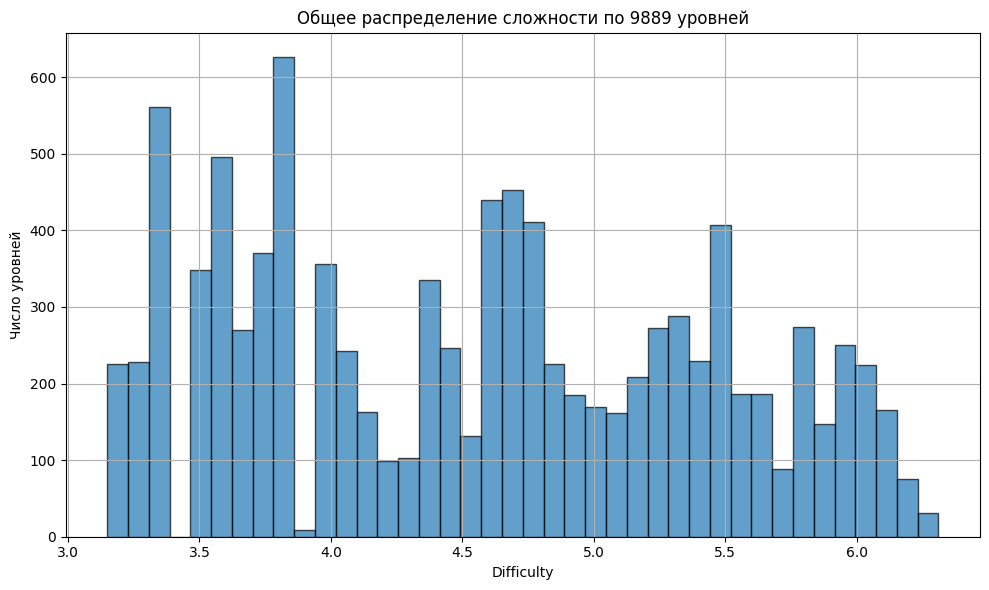

<Figure size 640x480 with 0 Axes>

In [26]:
# %% [markdown]
# Построение объединённого распределения Difficulty по 1000 уровней на каждую конфигурацию
# ─────────────────────────────────────────────────────────────

import random
from tqdm import trange
import matplotlib.pyplot as plt

# ваши функции и CONFIGS уже должны быть в окружении:
# load_agent_for_cfg, difficulty, CONFIGS = [...]
CONFIGS = [
    (3,1,4),(3,1,5),(4,1,4),(4,1,5),
    (4,2,4),(4,2,5),(5,1,4),(5,1,5),
    (5,2,4),(5,2,5),(6,2,4),(6,2,5),
    (7,2,4),(7,2,5),
]
levels_per_cfg = 1000

all_diffs = []

for cfg in CONFIGS:
    n, k_empty, l_layers = cfg
    agent, env = load_agent_for_cfg(cfg)
    diffs_cfg = []

    # для прогона таймера прогресса можно использовать trange
    for _ in trange(levels_per_cfg, desc=f"CFG={cfg}"):
        # 1) генерируем новый уровень
        obs, _ = env.reset(previous=False)
        initial = obs.copy().reshape(n, l_layers).tolist()

        # 2) запускаем агента, считаем шаги
        steps = 0
        done = False
        while not done and steps < env.env.max_steps:
            act = agent.sample_actions_masked(obs[None], env)[0]
            obs, _, done, _, _ = env.step(act)
            steps += 1

        # 3) если агент дошёл до победы — считаем сложность
        if done:
            d = difficulty(env, initial, steps)
            diffs_cfg.append(d)
        # иначе — пропускаем и переходим к следующему уровню

    print(f"— CFG={cfg}: собрано {len(diffs_cfg)}/{levels_per_cfg} решённых уровней")
    all_diffs.extend(diffs_cfg)

# — в итоге all_diffs содержит сложности всех успешно решённых уровней
print(f"\nВсего уровней для построения: {len(all_diffs)} "
      f"({len(CONFIGS)}×{levels_per_cfg} запрошено)")

# рисуем итоговую гистограмму
plt.figure(figsize=(10, 6))
plt.hist(all_diffs, bins=40, edgecolor='black', alpha=0.7)
plt.xlabel("Difficulty")
plt.ylabel("Число уровней")
plt.title(f"Общее распределение сложности по {len(all_diffs)} уровней")
plt.grid(True)
plt.tight_layout()
plt.show()

OUT_DIR = "../SortWaterAi/SortWaterAI/experiments/graphs/difficulty_distribution"
os.makedirs(OUT_DIR, exist_ok=True)

fname = os.path.join(
        OUT_DIR,
        f"diff_dist.png"
    )
plt.savefig(fname, dpi=200, bbox_inches="tight")


CFG=(7, 2, 5): 100%|██████████| 100/100 [05:11<00:00,  3.11s/it]

Средние значения по 100 уровням на каждую конфигурацию:



,bfs_time,agent_time,bfs_steps,agent_steps,agent_success,speedup(×)
cfg,,,,,,
3_1_4,0.000,0.000,4.510,5.074,0.959,0.453
3_1_5,0.000,0.001,5.277,5.967,0.979,0.454
4_1_4,0.000,0.001,7.590,8.196,0.590,0.689
4_1_5,0.001,0.001,9.642,10.633,0.448,0.730
4_2_4,0.002,0.000,4.390,4.390,1.000,5.482
4_2_5,0.005,0.001,5.650,5.650,1.000,9.732
5_1_4,0.001,0.001,10.863,10.833,0.235,1.079
5_1_5,0.002,0.001,14.467,15.333,0.100,1.121
5_2_4,0.030,0.001,8.180,8.677,0.990,32.366



✓ График и таблица сохранены в: graphs/alg_speed_comparison


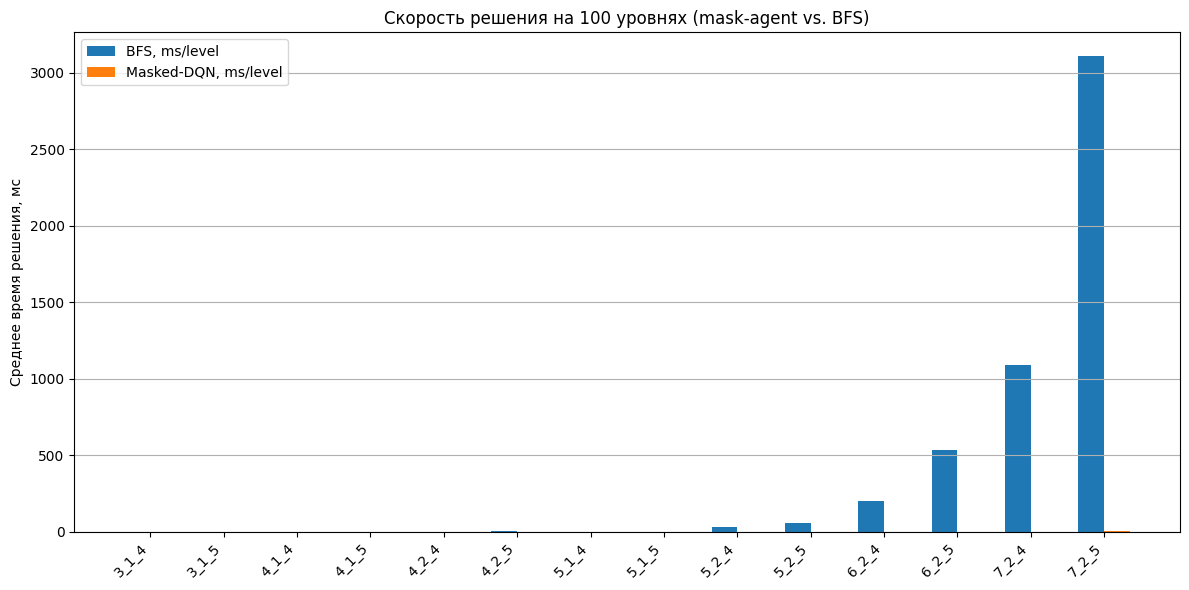

In [27]:
# %% [markdown]
# Сравнение времени решения: Masked-DQN vs. BFS
# ─────────────────────────────────────────────────────────────
#
# Для каждой конфигурации из CONFIGS:
#   • генерируем 100 случайных уровней;
#   • измеряем CPU-время и кол-во шагов, которые требуются
#     ─ обученному Masked-DQN-агенту;
#     ─ эталонному BFS-поиску (оптимальное решение);
#   • формируем сводную таблицу и строим график сравнения.

import os, time, random, json
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import trange

# -------------  зависимости, которые уже должны быть в окружении -------------
# • WaterSortEnvFixed           – само окружение
# • DiscreteActionWrapper       – обёртка Discrete
# • MaskedDQNAgent              – обученный агент
# • load_agent_for_cfg(cfg)     → (agent , env)
# • solve_optimal_path(env, s0) → (path , steps , … )

CONFIGS          = [
    (3,1,4),(3,1,5),(4,1,4),(4,1,5),
    (4,2,4),(4,2,5),(5,1,4),(5,1,5),
    (5,2,4),(5,2,5),(6,2,4),(6,2,5),
    (7,2,4),(7,2,5),
]
LEVELS_PER_CFG   = 100
BFS_TIMEOUT_EXP  = 200_000      # лимит узлов для BFS

results = []      # сюда пишем по-уровневую статистику

for cfg in CONFIGS:
    n, k_empty, l_layers = cfg
    agent, env = load_agent_for_cfg(cfg)

    for _ in trange(LEVELS_PER_CFG, desc=f"CFG={cfg}"):
        # ── 1. генерируем случайный уровень ────────────────────────────────
        obs0, _ = env.reset(previous=False)

        # ── 2. решаем BFS, замеряем время ──────────────────────────────────
        t0 = time.perf_counter()
        _, bfs_steps, _, _ = solve_optimal_path(
            env, obs0, max_expansions=BFS_TIMEOUT_EXP
        )
        bfs_time = time.perf_counter() - t0

        # если BFS не нашёл решение — пропускаем этот уровень
        if bfs_steps is None:
            continue

        # ── 3. решает агент ────────────────────────────────────────────────
        obs   = obs0.copy()
        a_sz, done = 0, False

        t1 = time.perf_counter()
        while not done and a_sz < env.env.max_steps:
            act  = agent.sample_actions_masked(obs[None], env)[0]
            obs, _, done, trunc, _ = env.step(act)
            a_sz += 1
            if trunc: break
        agent_time = time.perf_counter() - t1

        # пишем результат
        results.append({
            "cfg":        f"{n}_{k_empty}_{l_layers}",
            "bfs_steps":  bfs_steps,
            "bfs_time":   bfs_time,
            "agent_steps":a_sz if done else np.nan,
            "agent_time": agent_time if done else np.nan,
            "solved":     bool(done),
        })

# ----------  агрегируем в DataFrame и считаем средние -------------------------
df = pd.DataFrame(results)
summary = (df.groupby("cfg")[["bfs_time","agent_time",
                              "bfs_steps","agent_steps","solved"]]
             .agg({"bfs_time":"mean",
                   "agent_time":"mean",
                   "bfs_steps":"mean",
                   "agent_steps":"mean",
                   "solved":"mean"})              # доля успешно решённых
             .rename(columns={"solved":"agent_success"}))
summary["speedup(×)"] = summary["bfs_time"] / summary["agent_time"]

print("Средние значения по 100 уровням на каждую конфигурацию:\n")
display(summary.round(3))

# ----------  визуализация времени --------------------------------------------
fig, ax = plt.subplots(figsize=(12,6))
x = np.arange(len(summary))
w = 0.35

ax.bar(x - w/2, summary["bfs_time"]*1000,  width=w, label="BFS, ms/level")
ax.bar(x + w/2, summary["agent_time"]*1000, width=w, label="Masked-DQN, ms/level")

ax.set_xticks(x); ax.set_xticklabels(summary.index, rotation=45, ha="right")
ax.set_ylabel("Среднее время решения, мс")
ax.set_title(f"Скорость решения на {LEVELS_PER_CFG} уровнях (mask-agent vs. BFS)")
ax.legend(); ax.grid(axis="y")

plt.tight_layout()

# ----------  сохраняем --------------------------------------------------------
OUT_DIR = "../SortWaterAi/SortWaterAI/experiments/graphs/alg_speed_comparison"
os.makedirs(OUT_DIR, exist_ok=True)

fig.savefig(os.path.join(OUT_DIR, "speed_comparison.png"), dpi=200)
summary.to_csv(os.path.join(OUT_DIR, "speed_comparison.csv"))

print(f"\n✓ График и таблица сохранены в: {OUT_DIR}")
